In [1]:
import warnings
warnings.filterwarnings("ignore",
    message="Values in x were outside bounds during a minimize step, clipping",
    category=RuntimeWarning, module="scipy.optimize._slsqp")

In [ ]:
import numpy as np
import pandas as pd
import time
from scipy.stats import beta as beta_rv, t as t_rv
from scipy.optimize import minimize
from scipy.special import betaln
from arch import arch_model
import matplotlib.pyplot as plt

np.random.seed(123)

# Innovations, simulation, Beta moments

def standardized_beta_sample(a, b, size):
    """Draw Beta(a,b), standardize to mean 0, var 1."""
    raw = beta_rv.rvs(a, b, size=size)
    mu = a / (a + b)
    var = (a * b) / ((a + b) ** 2 * (a + b + 1))
    return (raw - mu) / np.sqrt(var)

def standardized_t_sample(df, size):
    """Draw t(df), standardize to mean 0, var 1 (df>2)."""
    raw = t_rv.rvs(df, size=size)
    return raw / np.sqrt(df / (df - 2)) if df > 2 else raw

def simulate_garch(omega, alpha, beta_, eps):
    """
    Simulate GARCH(1,1): y_t = sigma_t * eps_t, 
    sigma_t^2 = omega + alpha*y_{t-1}^2 + beta_*sigma_{t-1}^2.
    """
    T = len(eps)
    sigma2 = np.zeros(T, float)
    y = np.zeros(T, float)
    # Initialize at unconditional variance if stationary
    sigma2[0] = omega / max(1e-12, (1.0 - alpha - beta_)) if (alpha + beta_ < 0.999) else np.var(eps)
    y[0] = np.sqrt(sigma2[0]) * eps[0]
    for t in range(1, T):
        sigma2[t] = omega + alpha * y[t-1]**2 + beta_ * sigma2[t-1]
        sigma2[t] = max(sigma2[t], 1e-12)
        y[t] = np.sqrt(sigma2[t]) * eps[t]
    return y, sigma2

def beta_mean_std(a, b):
    """Return (mean, std) of Beta(a,b)."""
    mu = a / (a + b)
    var = (a * b) / ((a + b) ** 2 * (a + b + 1))
    return mu, np.sqrt(var)

# STABLE BETA-MLE OBJECTIVE (finite everywhere)

def _reconstruct_sigma2(y, omega, alpha, beta_):
    """Internal recursion with defensive floors."""
    y = np.asarray(y, float)
    T = len(y)
    s2 = np.zeros(T, float)
    s2[0] = (omega / max(1e-12, 1 - alpha - beta_)) if (alpha + beta_ < 0.999) else np.var(y)
    for t in range(1, T):
        s2[t] = omega + alpha * y[t-1]**2 + beta_ * s2[t-1]
        if not np.isfinite(s2[t]) or s2[t] <= 0:
            s2[t] = 1e-12
    return s2

def beta_mle_negloglik(theta, y, penalty_scale=1e6):
    """
    Negative log-likelihood for Beta-innovation GARCH with *finite* soft penalty
    outside support. Always returns a finite float for optimizer stability.
    theta = (omega, alpha, beta_, a, b)
    """
    omega, alpha, beta_, a, b = map(float, theta)
    # Basic feasibility checks (still hard)
    if (omega <= 0) or (alpha < 0) or (beta_ < 0) or (alpha + beta_ >= 1 - 5e-3) or (a <= 0) or (b <= 0):
        # Large but finite penalty
        return penalty_scale * 1e4

    y = np.asarray(y, float)
    T = len(y)

    # GARCH variance
    sigma2 = _reconstruct_sigma2(y, omega, alpha, beta_)
    sigma_t = np.sqrt(np.maximum(sigma2, 1e-12))

    # Map standardized residuals to Beta support
    mu_w, sigma_w = beta_mean_std(a, b)
    # Avoid degenerate sigma_w
    sigma_w = max(sigma_w, 1e-8)

    z = y / sigma_t
    beta_arg = mu_w + sigma_w * z

    # Soft penalty for out-of-support values (finite)
    outside_lo = beta_arg <= 0
    outside_hi = beta_arg >= 1
    if np.any(outside_lo) or np.any(outside_hi):
        dist = np.zeros_like(beta_arg)
        dist[outside_lo] = -beta_arg[outside_lo]
        dist[outside_hi] = beta_arg[outside_hi] - 1.0
        # Quadratic distance + linear count penalty
        return penalty_scale * (np.sum(dist**2) + 0.01 * (outside_lo.sum() + outside_hi.sum()))

    # Stable logs
    eps = 1e-12
    beta_arg = np.clip(beta_arg, eps, 1 - eps)
    # loglike up to additive constants
    loglike = (
        (a - 1.0) * np.log(beta_arg)
        + (b - 1.0) * np.log1p(-beta_arg)
        - betaln(a, b)
        + np.log(sigma_w)
        - np.log(sigma_t)
    )
    nll = -np.sum(loglike)
    # Guard against NaNs
    if not np.isfinite(nll):
        return penalty_scale * 1e4
    return nll

# ESTIMATION ROUTINES (SLSQP Optimization Algorithm for Beta-MLE)

# --- QMLE (Gaussian) ---
def estimate_qmle(y):
    """Return [omega, alpha, beta] using arch (Gaussian QMLE)."""
    try:
        model = arch_model(y, mean='zero', vol='GARCH', p=1, q=1, dist='normal')
        res = model.fit(disp='off', show_warning=False)
        p = res.params
        return [float(p['omega']), float(p['alpha[1]']), float(p['beta[1]'])]
    except Exception:
        return [np.nan, np.nan, np.nan]

# --- t-MLE (via arch) ---
def estimate_t_mle(y):
    """Return [omega, alpha, beta, df] using arch (Student-t)."""
    model = arch_model(y, mean='zero', vol='GARCH', p=1, q=1, dist='t')
    res = model.fit(disp='off', show_warning=False)
    p = res.params
    return [float(p['omega']), float(p['alpha[1]']), float(p['beta[1]']), float(p['nu'])]

# --- Beta-MLE (robust SLSQP) ---
def _project_stationary(alpha, beta_, margin=0.02):
    """Ensure alpha+beta <= 1 - margin."""
    s = alpha + beta_
    cap = 1.0 - margin
    if s >= cap:
        if s <= 1e-12:
            return max(alpha, 1e-6), max(beta_, 1e-6)
        scale = cap / s
        return max(alpha * scale, 1e-6), max(beta_ * scale, 1e-6)
    return max(alpha, 1e-6), max(beta_, 1e-6)

def estimate_beta_mle(y, theta0=None, bounds=None, restarts=5, seed=2025):
    """
    SLSQP with:
      - strictly feasible warm-start (uses QMLE for omega,alpha,beta)
      - margin on stationarity (alpha+beta <= 1-5e-3)
      - large upper bounds for a,b to widen admissible z-range
      - finite soft penalties in the objective
      - random restarts if the first try fails
    Returns [omega, alpha, beta, a, b] or None.
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y, float)

    # Bounds (can be tweaked)
    if bounds is None:
        bounds = [
            (1e-8, None),          # omega > 0
            (1e-8, 1.0 - 5e-3),    # alpha >= 0
            (1e-8, 1.0 - 5e-3),    # beta  >= 0
            (1.0, 300.0),          # a >= 1, allow large
            (1.0, 300.0)           # b >= 1
        ]

    # Warm-start: QMLE for (omega,alpha,beta), large a,b init
    if theta0 is None:
        om, al, be = estimate_qmle(y)
        # Safe defaults if QMLE fails
        if not np.isfinite(om): om = np.var(y) * 0.05
        if not np.isfinite(al): al = 0.05
        if not np.isfinite(be): be = 0.90
        al, be = _project_stationary(al, be, margin=0.02)
        a0, b0 = 20.0, 20.0       # generous a,b so sigma_w is small => wide z-range
        theta0 = np.array([om, al, be, a0, b0], float)
    else:
        theta0 = np.array(theta0, float)
        theta0[1], theta0[2] = _project_stationary(theta0[1], theta0[2], margin=0.02)
        theta0[0] = max(theta0[0], 1e-8)
        theta0[3] = max(theta0[3], 1.0)
        theta0[4] = max(theta0[4], 1.0)

    # Nonlinear stationarity constraint with margin
    nlc = {'type': 'ineq', 'fun': lambda th: (1.0 - 5e-3) - (th[1] + th[2])}

    def _run_once(th0):
        res = minimize(
            beta_mle_negloglik, th0, args=(y,),
            method='SLSQP',
            bounds=bounds,
            constraints=[nlc],
            options={'maxiter': 2000, 'ftol': 1e-9, 'eps': 1e-6, 'disp': False}
        )
        return res

    # Try initial run
    best = None
    res = _run_once(theta0)
    if res.success and np.isfinite(res.fun):
        best = res

    # Random restarts around feasible region
    for _ in range(restarts):
        th = theta0.copy()
        # jitter omega, alpha, beta mildly
        th[:3] *= rng.uniform(0.7, 1.3, size=3)
        th[1], th[2] = _project_stationary(th[1], th[2], margin=0.02)
        # restart a,b in a wide box
        th[3:] = rng.uniform(5.0, 60.0, size=2)
        res2 = _run_once(th)
        if res2.success and np.isfinite(res2.fun):
            if (best is None) or (res2.fun < best.fun):
                best = res2

    if best is not None:
        return list(best.x)
    # Last resort: return None so caller can record NaNs
    print("Beta-MLE Optimization failed:", res.message if res is not None else "unknown")
    return None

# EXPERIMENT DESIGN

GARCH_PARAMS = {
    'A': (0.10, 0.10, 0.80),  # High persistence
    'B': (0.05, 0.05, 0.90),  # Very high persistence
    'C': (0.20, 0.15, 0.70),  # Moderate persistence
}

INNOVATIONS = [
    ('Beta', (2, 5)),
    ('Beta', (5, 2)),
    ('Beta', (3, 3)),
    ('t', 3),
    ('t', 8),
    ('t', 12),
    ('normal', None)
]

T = 1000   # series length
N = 1000    # replications number

# 5) SIMULATION + ESTIMATION LOOP

start_time = time.time()
all_results = []

for case, (omega, alpha, beta_) in GARCH_PARAMS.items():
    for innov_type, innov_param in INNOVATIONS:
        print(f"\nStarting {case}-{innov_type}-{innov_param}")
        for rep in range(N):
            # --- Innovations
            if innov_type == 'Beta':
                a, b = innov_param
                eps = standardized_beta_sample(a, b, T)
            elif innov_type == 't':
                df = innov_param
                eps = standardized_t_sample(df, T)
            else:
                eps = np.random.normal(0.0, 1.0, T)

            # --- Simulate
            y, sigma2 = simulate_garch(omega, alpha, beta_, eps)

            # --- Beta-MLE (robust SLSQP)
            theta0_beta = [omega, alpha, beta_, 20.0, 20.0]  # generous start for a,b
            beta_est = estimate_beta_mle(y, theta0=theta0_beta)
            if beta_est is None:
                beta_est = [np.nan]*5

            # --- t-MLE & QMLE (arch)
            try:
                o_t, a_t, b_t, nu_t = estimate_t_mle(y)
            except Exception:
                o_t, a_t, b_t, nu_t = [np.nan]*4

            o_q, a_q, b_q = estimate_qmle(y)

            # --- Store
            all_results.append({
                'case': case,
                'innov_type': innov_type,
                'innov_param': str(innov_param),
                'rep': rep,
                'omega_true': omega, 'alpha_true': alpha, 'beta_true': beta_,
                'a_true': innov_param[0] if innov_type == 'Beta' else np.nan,
                'b_true': innov_param[1] if innov_type == 'Beta' else np.nan,
                'df_true': innov_param if innov_type == 't' else np.nan,
                'omega_beta': beta_est[0], 'alpha_beta': beta_est[1], 'beta_beta': beta_est[2],
                'a_beta': beta_est[3], 'b_beta': beta_est[4],
                'omega_t': o_t, 'alpha_t': a_t, 'beta_t': b_t, 'df_t': nu_t,
                'omega_qmle': o_q, 'alpha_qmle': a_q, 'beta_qmle': b_q,
                'y_series': y.tolist(),
                'sigma2_true': sigma2.tolist()
            })

        elapsed = (time.time() - start_time)/60
        print(f"  Completed {N}/{N} replications ({elapsed:.1f} min elapsed)")

print("\nSimulation complete! Results in `all_results`.")


Starting A-Beta-(2, 5)
  Completed 300/300 replications (21.4 min elapsed)

Starting A-Beta-(5, 2)
  Completed 300/300 replications (41.9 min elapsed)

Starting A-Beta-(3, 3)


Using fixed rep = 134
RMSE vs True  |  returns (y_t)   volatility (sigma_t)
Beta‑MLE          0.0107            0.0103
t‑MLE             0.0273            0.0265
QMLE              0.0271            0.0263


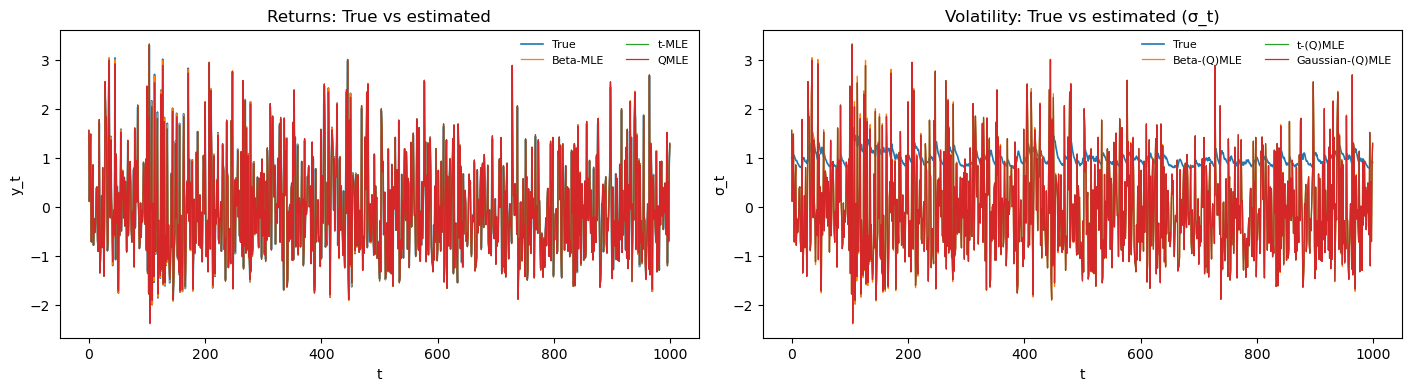

RMSE vs True  |  returns (y_t)   volatility (sigma_t)
Beta‑MLE          0.1148            0.1369
t‑MLE             0.0865            0.1033
QMLE              0.1171            0.1397


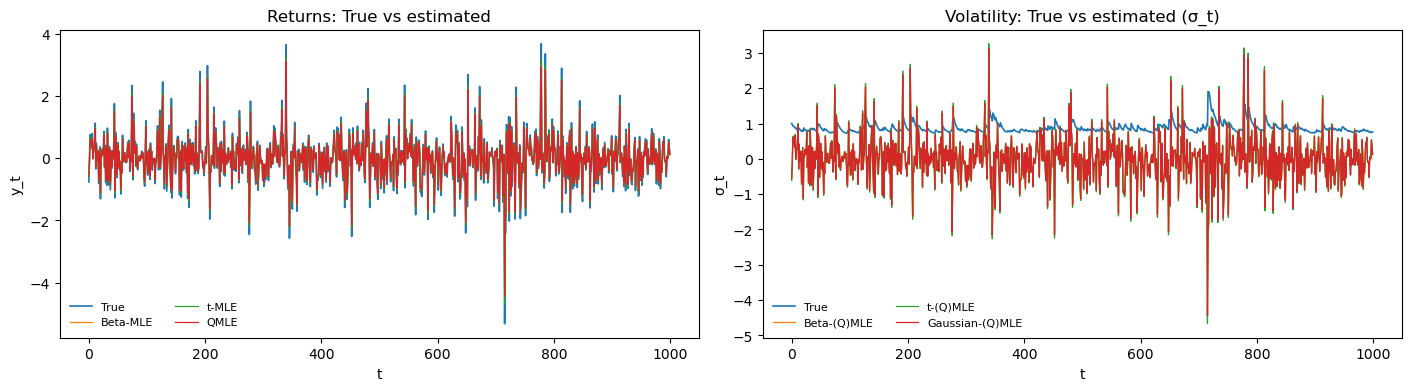

RMSE vs True  |  returns (y_t)   volatility (sigma_t)
Beta‑MLE          0.0137            0.0134
t‑MLE             0.0159            0.0155
QMLE              0.0153            0.0150


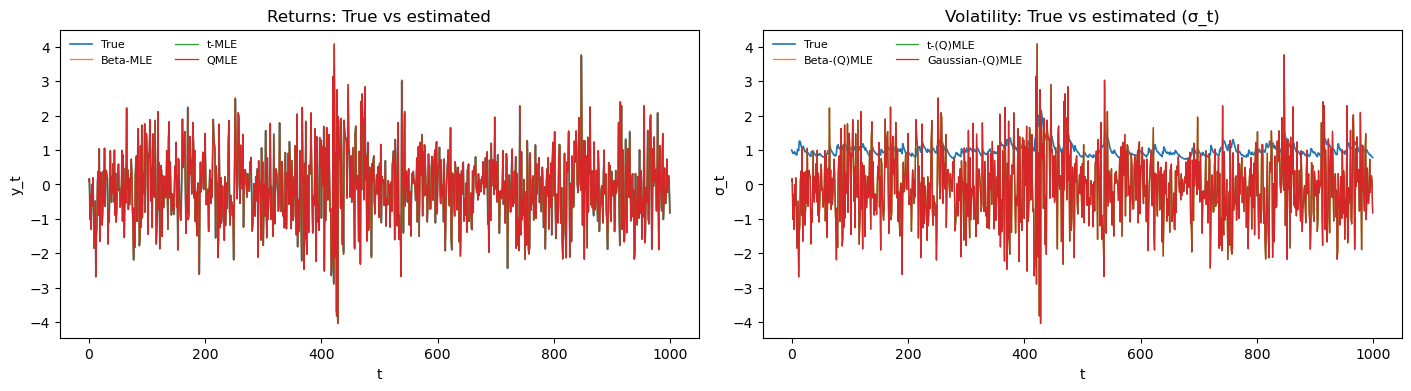

In [ ]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  
import matplotlib.pyplot as plt

def _beta_ok(row):
    return np.all(np.isfinite([
        row['omega_beta'], row['alpha_beta'], row['beta_beta'],
        row['a_beta'], row['b_beta']
    ]))

# Pick a specific row by replication index and use the moderate GARCH model parameter setting, case C
def rows_for_fixed_rep(all_results, targets, case='A', rep=0, require_beta=True):
    rows = []
    failures = []

    # Try to fetch exactly that rep for each target
    for itype, iparam in targets:
        target = str(iparam)
        match = [r for r in all_results
                 if r['case'] == case
                 and r['innov_type'] == itype
                 and r['innov_param'] == target
                 and r['rep'] == rep]
        if not match:
            failures.append((itype, iparam, 'missing'))
            continue
        row = match[0]
        if require_beta and itype is not None and not _beta_ok(row):
            failures.append((itype, iparam, 'beta_fail'))
        else:
            rows.append(row)

    if failures:
        avail = {}
        for itype, iparam in targets:
            target = str(iparam)
            reps_ok = sorted({
                r['rep'] for r in all_results
                if r['case'] == case
                and r['innov_type'] == itype
                and r['innov_param'] == target
                and (not require_beta or _beta_ok(r))
            })
            avail[(itype, target)] = reps_ok
        common = sorted(set.intersection(*(set(v) for v in avail.values()))) if avail else []

        msg = [
            f"[rows_for_fixed_rep] Requested rep={rep} is not usable for all targets.",
            f"  Failures (type, param, reason): {failures}",
            f"  Common reps with success across ALL targets: {common if common else 'None'}",
            "  Per-target available reps:",
        ]
        for k, v in avail.items():
            msg.append(f"    {k}: {v if v else 'None'}")
        raise RuntimeError("\n".join(msg))

    return rep, rows
# Function to obtain the simulated(true) volatility or estimated volatility
def reconstruct_sigma2(y, omega, alpha, beta_):
    y = np.asarray(y, float)
    T = len(y)
    s2 = np.zeros(T, float)
    s2[0] = (omega/(1 - alpha - beta_)) if (alpha + beta_ < 0.999) else np.var(y)
    for t in range(1, T):
        s2[t] = omega + alpha*y[t-1]**2 + beta_*s2[t-1]
    return np.maximum(s2, 1e-12)
# There are different ways to construct errors used to construct estimated returns, we use the true shocks in our comparison, because it is more suitable for estimation performance comparison under different innovations
def build_bundle(row, eps_source="true", ref_model="QMLE"):
    y = np.asarray(row['y_series'], float)

    # true volatility & shocks
    s_true = np.sqrt(reconstruct_sigma2(y, row['omega_true'], row['alpha_true'], row['beta_true']))
    if eps_source == "true":
        eps = y / s_true

    s_hat = {}
    # Beta‑MLE
    if all(np.isfinite([row['omega_beta'], row['alpha_beta'], row['beta_beta']])):
        s_hat['Beta‑MLE'] = np.sqrt(reconstruct_sigma2(y, row['omega_beta'], row['alpha_beta'], row['beta_beta']))
    # t‑MLE
    s_hat['t‑MLE'] = np.sqrt(reconstruct_sigma2(y, row['omega_t'], row['alpha_t'], row['beta_t']))
    # QMLE
    s_hat['QMLE']  = np.sqrt(reconstruct_sigma2(y, row['omega_qmle'], row['alpha_qmle'], row['beta_qmle']))

    if eps_source == "ref":
        s_ref = s_hat[ref_model]
        eps = y / s_ref

    # estimated return series
    y_hat = {name: s * eps for name, s in s_hat.items()}

    return dict(y_true=y, s_true=s_true, y_hat=y_hat, s_hat=s_hat)
# Compute RMSE
def rmse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

def print_rmse(bundle):
    y_true = bundle['y_true']; s_true = bundle['s_true']
    print("RMSE vs True  |  returns (y_t)   volatility (sigma_t)")
    for k in bundle['y_hat'].keys():
        r1 = rmse(y_true, bundle['y_hat'][k])
        r2 = rmse(s_true, bundle['s_hat'][k])
        print(f"{k:10s}    {r1:10.4f}        {r2:10.4f}")
label_map = {
    'Beta‑MLE': 'Beta-(Q)MLE',
    't‑MLE': 't-(Q)MLE',
    'QMLE': 'Gaussian-(Q)MLE',
}
# Plot function
def plot_two_panel(row, bundle, shock_label="true"):
    T = len(bundle['y_true']); tgrid = np.arange(T)
    fig, axes = plt.subplots(1, 2, figsize=(14, 3.8), constrained_layout=True)

    # Returns
    ax = axes[0]
    ax.plot(tgrid, bundle['y_true'], lw=1.2, label='True')
    for k, yhat in bundle['y_hat'].items():
        ax.plot(tgrid, yhat, lw=0.9, label=k)
    ax.set_title(f"Returns: True vs estimated")
    ax.set_xlabel("t"); ax.set_ylabel("y_t")
    ax.legend(ncols=2, fontsize=8, frameon=False)

    # Volatility
    ax = axes[1]
    ax.plot(tgrid, bundle['s_true'], lw=1.2, label='True')
    for k, yhat in bundle['y_hat'].items():
        label = label_map.get(k, k)  
        ax.plot(tgrid, yhat, lw=0.9, label=label)
    ax.set_title("Volatility: True vs estimated (σ_t)")
    ax.set_xlabel("t"); ax.set_ylabel("σ_t")
    ax.legend(ncols=2, fontsize=8, frameon=False)
    plt.show()

# The targets (order matters; plots will follow this order)
targets = [
    ('Beta',   (2, 5)),
    ('t',      3),
    ('normal', None),
]

# Choose the exact realization you want:
np.random.seed(198)
fix_rep = np.random.randint(0, 301)

# Get rows for that fixed rep (requires Beta‑MLE success by default)
rep, rows = rows_for_fixed_rep(all_results, targets, case='A', rep=fix_rep, require_beta=True)
print(f"Using fixed rep = {rep}")

# Plot each target using true ε_t 
for r in rows:
    bundle = build_bundle(r, eps_source="true")
    print_rmse(bundle)
    plot_two_panel(r, bundle, shock_label=f"true (rep={rep})")


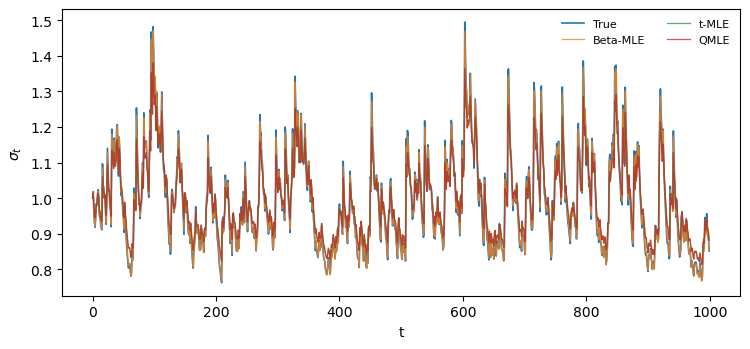

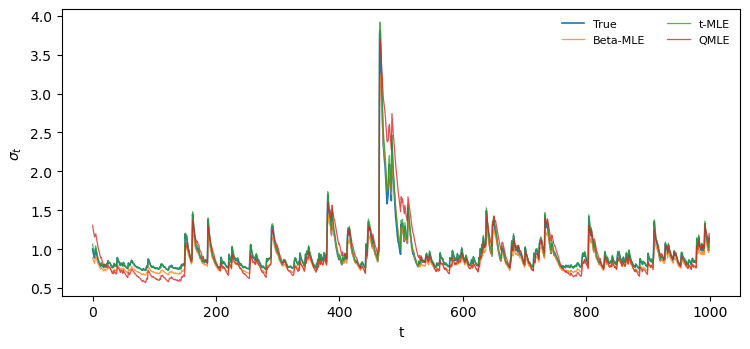

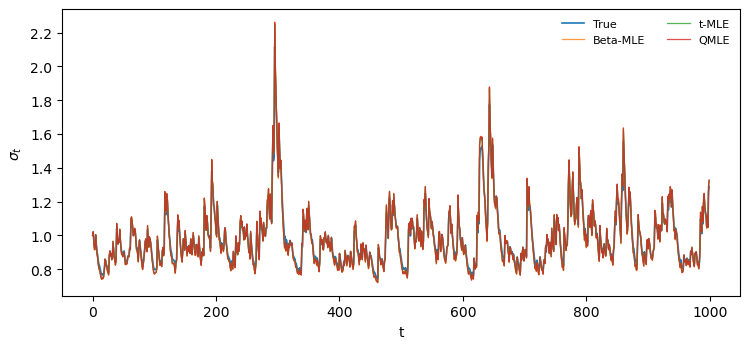

In [256]:
# --- new plot function: volatility only ---
def plot_volatility_only(bundle, rep=None, innov_label=None):
    T = len(bundle['s_true'])
    t = np.arange(T)

    plt.figure(figsize=(7.6, 3.6))
    # true path
    plt.plot(t, bundle['s_true'], lw=1.2, label='True')
    # estimated paths
    for name, s in bundle['s_hat'].items():
        plt.plot(t, s, lw=0.9, label=name,alpha = 0.8)

    plt.xlabel("t")
    plt.ylabel(r"$\sigma_t$")
    plt.legend(ncols=2, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()


# --- choose targets and replication as before ---
targets = [
    ('Beta',   (2, 5)),
    ('t',      3),
    ('normal', None),
]

np.random.seed(198)
fix_rep = np.random.randint(0, 301)

# --- fetch rows for that replication (requires Beta-MLE success by default) ---
rep, rows = rows_for_fixed_rep(all_results, targets, case='A', rep=fix_rep, require_beta=True)

# --- build and plot (no RMSE, no returns panel) ---
for r in rows:
    bundle = build_bundle(r, eps_source="true")  # eps doesn't matter for volatility
    label = f"{r['innov_type']} innovation, param={r['innov_param']}"
    plot_volatility_only(bundle, rep=rep, innov_label=label)


In [257]:
import matplotlib
matplotlib.use('PDF') 
import matplotlib.pyplot as plt

def plot_volatility_only(bundle, rep=None, innov_label=None):
    T = len(bundle['s_true'])
    t = np.arange(T)

    plt.figure(figsize=(7.6, 3.6))
    plt.plot(t, bundle['s_true'], lw=1.5, label='True')  
    
    for name, s in bundle['s_hat'].items():
        plt.plot(t, s, lw=0.9, label=name, alpha=0.8)

    plt.xlabel("t", fontsize=13)
    plt.ylabel("$\sigma_t$",fontsize=13)  
    plt.legend(ncols=2, fontsize=10, frameon=False)
    plt.tight_layout()
    
    filename = f"volatility_rep{rep}_{innov_label.replace(' ', '_')}.pdf"
    plt.savefig(filename) 
    plt.close()  

targets = [
    ('Beta', (2, 5)),
    ('t', 3),
    ('normal', None),
]

np.random.seed(198)
fix_rep = np.random.randint(0, 301)

rep, rows = rows_for_fixed_rep(all_results, targets, case='A', rep=fix_rep, require_beta=True)

for r in rows:
    bundle = build_bundle(r, eps_source="true")
    label = f"{r['innov_type']}_innovation_param={r['innov_param']}"  
    plot_volatility_only(bundle, rep=rep, innov_label=label)

In [6]:
from collections import defaultdict
# RMSE and NRMSE
ESTIMATOR_FIELDS = {
    "Beta-MLE":      ("omega_beta",  "alpha_beta",  "beta_beta"),
    "t-MLE":         ("omega_t",     "alpha_t",     "beta_t"),
    "Gaussian-QMLE": ("omega_qmle",  "alpha_qmle",  "beta_qmle"),
}
PARAMS = ("omega", "alpha", "beta")

def _safe_num(x):
    try:
        return float(x)
    except Exception:
        return np.nan
def beta_fit_ok(rec, c_var=50.0, c_true=100.0): # Return False if the Beta-MLE estimate is clearly bad.
    try:
        om = float(rec.get('omega_beta'))
        a  = float(rec.get('alpha_beta'))
        b  = float(rec.get('beta_beta'))
        aa = float(rec.get('a_beta'))
        bb = float(rec.get('b_beta'))
    except Exception:
        return False

    if not np.all(np.isfinite([om, a, b, aa, bb])): return False
    if om <= 0 or a < 0 or b < 0 or a + b >= 1 - 1e-6 or aa <= 0 or bb <= 0: return False

    y = np.asarray(rec.get('y_series'), float)
    var_y = float(np.var(y)) if np.isfinite(np.var(y)) else 1.0
    if om > c_var * max(var_y, 1e-8):   # too big for the data scale
        return False

    om_true = rec.get('omega_true')
    if np.isfinite(om_true) and om > c_true * max(float(om_true), 1e-8):  # too big vs truth
        return False

    return True
def _collect_errors_long(all_results): # Construct the table 
    fail_count = defaultdict(int)
    total_count = defaultdict(int)

    rows = []
    for rec in all_results:
        key = (rec['case'], rec['innov_type'], rec['innov_param'], 'Beta-MLE')
        if rec['innov_type'] == 't':
            total_count[key] += 1
            if not beta_fit_ok(rec):
                fail_count[key] += 1
                continue # handle strange/extreme values
        case = rec.get('case')
        itype = rec.get('innov_type')
        iparam = rec.get('innov_param')
        rep = rec.get('rep')

        omega_true = _safe_num(rec.get('omega_true'))
        alpha_true = _safe_num(rec.get('alpha_true'))
        beta_true  = _safe_num(rec.get('beta_true'))

        for est, (k_om, k_al, k_be) in ESTIMATOR_FIELDS.items():
            om_hat = _safe_num(rec.get(k_om))
            al_hat = _safe_num(rec.get(k_al))
            be_hat = _safe_num(rec.get(k_be))

            # consider NaN situation
            if not np.any(np.isfinite([om_hat, al_hat, be_hat])):
                continue

            rows.append({
                'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
                'estimator': est,
                'err_omega': om_hat - omega_true,
                'err_alpha': al_hat - alpha_true,
                'err_beta' : be_hat  - beta_true,
                'true_omega': omega_true, 'true_alpha': alpha_true, 'true_beta': beta_true
            })
    return pd.DataFrame(rows)

def _rmse(arr):
    x = pd.Series(arr, dtype=float)
    x = x[np.isfinite(x)]
    if x.empty: return np.nan
    return float(np.sqrt(np.mean(np.square(x))))

def compute_rmse_table(all_results):
    df = _collect_errors_long(all_results)
    if df.empty:
        return pd.DataFrame(columns=[
            'case','innov_type','innov_param','estimator',
            'rmse_omega','rmse_alpha','rmse_beta'
        ])
    rmse_tbl = (df.groupby(['case','innov_type','innov_param','estimator'], dropna=False)
                  .agg(rmse_omega=('err_omega', _rmse),
                       rmse_alpha=('err_alpha', _rmse),
                       rmse_beta =('err_beta',  _rmse))
                  .reset_index())
    return rmse_tbl

def compute_nrmse_table(all_results, eps=1e-12):
    df = _collect_errors_long(all_results)
    if df.empty:
        return pd.DataFrame(columns=[
            'case','innov_type','innov_param','estimator',
            'nrmse_omega','nrmse_alpha','nrmse_beta'
        ])

    rmse_tbl = compute_rmse_table(all_results)

    # Ture value for those three parameters, omega, alpha, beta
    tru = (df.groupby(['case','innov_type','innov_param'], dropna=False)
             .agg(true_omega=('true_omega','first'),
                  true_alpha=('true_alpha','first'),
                  true_beta =('true_beta','first'))
             .reset_index())

    out = rmse_tbl.merge(tru, on=['case','innov_type','innov_param'], how='left')

    def _nrmse(rmse, true_val):
        if not np.isfinite(rmse) or not np.isfinite(true_val): return np.nan
        denom = abs(true_val)
        return float(rmse if denom < eps else rmse / denom)

    out['nrmse_omega'] = out.apply(lambda r: _nrmse(r['rmse_omega'], r['true_omega']), axis=1)
    out['nrmse_alpha'] = out.apply(lambda r: _nrmse(r['rmse_alpha'], r['true_alpha']), axis=1)
    out['nrmse_beta']  = out.apply(lambda r: _nrmse(r['rmse_beta'],  r['true_beta']),  axis=1)

    return out[['case','innov_type','innov_param','estimator',
                'nrmse_omega','nrmse_alpha','nrmse_beta']]

rmse_table  = compute_rmse_table(all_results)
nrmse_table = compute_nrmse_table(all_results)

# print("RMSE by setting × estimator:")
# print(rmse_table.sort_values(['case','innov_type','innov_param','estimator']).head(12))

# print("\nNRMSE by setting × estimator:")
# print(nrmse_table.sort_values(['case','innov_type','innov_param','estimator']).head(12))
# Print the result for each estimator one by one
pivot_nrmse_omega = (nrmse_table
    .pivot(index=['case','innov_type','innov_param'], columns='estimator', values='nrmse_omega'))
print("\nPivot: NRMSE(omega) per setting:")
print(pivot_nrmse_omega)

pivot_nrmse_alpha = (nrmse_table
    .pivot(index=['case','innov_type','innov_param'], columns='estimator', values='nrmse_alpha'))
print("\nPivot: NRMSE(alpha) per setting:")
print(pivot_nrmse_alpha)

pivot_nrmse_beta = (nrmse_table
    .pivot(index=['case','innov_type','innov_param'], columns='estimator', values='nrmse_beta'))
print("\nPivot: NRMSE(beta) per setting:")
print(pivot_nrmse_beta)

pivot_rmse_omega = (rmse_table
    .pivot(index=['case','innov_type','innov_param'], columns='estimator', values='rmse_omega'))
print("\nPivot: RMSE(omega) per setting:")
print(pivot_rmse_omega)

pivot_rmse_alpha = (rmse_table
    .pivot(index=['case','innov_type','innov_param'], columns='estimator', values='rmse_alpha'))
print("\nPivot: RMSE(alpha) per setting:")
print(pivot_nrmse_alpha)

pivot_rmse_beta = (rmse_table
    .pivot(index=['case','innov_type','innov_param'], columns='estimator', values='rmse_beta'))
print("\nPivot: RMSE(beta) per setting:")
print(pivot_nrmse_beta)


Pivot: NRMSE(omega) per setting:
estimator                    Beta-MLE  Gaussian-QMLE     t-MLE
case innov_type innov_param                                   
A    Beta       (2, 5)       0.316901       0.550580  0.550594
                (3, 3)       0.391392       0.467745  0.575607
                (5, 2)       0.314005       0.706449  0.971283
     normal     None         0.810922       0.698947  0.798382
     t          12           0.725405       0.659116  0.626268
                3            2.128318       1.165382  0.577598
                8            0.594601       0.592378  0.564125
B    Beta       (2, 5)       0.527078       1.107547  3.199281
                (3, 3)       1.570365       2.379822  4.634190
                (5, 2)       0.557488       1.144203  2.187224
     normal     None         2.390171       1.672199  2.426738
     t          12           1.975856       1.160409  1.572392
                3            6.433750       3.026207  1.039364
                8    

In [7]:
from numpy.linalg import LinAlgError

def beta_mean_std(a, b):
    a = float(a); b = float(b)
    mu = a / (a + b)
    var = (a * b) / ((a + b)**2 * (a + b + 1.0))
    return mu, float(np.sqrt(max(var, 0.0)))

def _reconstruct_sigma2(y, omega, alpha, beta_):
    # Standard GARCH(1,1) recursion for conditional variance.
    y = np.asarray(y, float)
    T = y.shape[0]
    s2 = np.empty(T, dtype=float)
    ab = alpha + beta_
    s2_0 = omega / (1.0 - ab) if (omega > 0 and 0 <= ab < 1.0) else max(y[0]**2, omega)
    s2[0] = float(max(s2_0, 1e-12))
    for t in range(1, T):
        s2[t] = omega + alpha * y[t-1]**2 + beta_ * s2[t-1]
        if not np.isfinite(s2[t]): s2[t] = 1e6
    return s2

def beta_mle_negloglik(theta, y, penalty_scale=1e6):
    omega, alpha, beta_, a, b = map(float, theta)
    y = np.asarray(y, float)

    # base penalties (positivity, stationarity-ish)
    pen = 0.0
    if omega <= 0: pen += (1 - 1e-6 - omega)**2
    if alpha < 0:  pen += (0 - alpha)**2
    if beta_ < 0:  pen += (0 - beta_)**2
    if a <= 0:     pen += (1 - 1e-6 - a)**2
    if b <= 0:     pen += (1 - 1e-6 - b)**2
    if alpha + beta_ >= 1 - 5e-3:
        pen += (alpha + beta_ - (1 - 5e-3))**2 * 1e2  # stronger near unit root

    s2 = _reconstruct_sigma2(y, omega, alpha, beta_)
    sig = np.sqrt(np.maximum(s2, 1e-12))
    mu_w, sd_w = beta_mean_std(a, b)
    sd_w = max(sd_w, 1e-8)

    z = y / sig
    w = mu_w + sd_w * z

    # soft barrier for w ∈ (0,1)
    # outside (0,1) add quadratic distance * big weight; inside clip for log
    dist_left  = np.maximum(0.0, 0.0 - w)
    dist_right = np.maximum(0.0, w - 1.0)
    pen += np.sum(dist_left**2 + dist_right**2) * 1e2

    eps = 1e-12
    w_clip = np.clip(w, eps, 1 - eps)

    ll_terms = (
        (a - 1.0) * np.log(w_clip)
        + (b - 1.0) * np.log1p(-w_clip)
        - betaln(a, b)
        + np.log(sd_w)
        - np.log(sig)
    )
    nll = -float(np.sum(ll_terms)) + penalty_scale * pen
    return nll

# SE for Beta-MLE
def numerical_hessian(f, x, eps=2e-5): # epsilon is the Hessian step
    x = np.asarray(x, float)
    k = x.size
    H = np.zeros((k, k), float)
    for i in range(k):
        for j in range(i, k):
            ei = np.zeros_like(x); ei[i] = eps
            ej = np.zeros_like(x); ej[j] = eps
            fpp = f(x + ei + ej)
            fpm = f(x + ei - ej)
            fmp = f(x - ei + ej)
            fmm = f(x - ei - ej)
            H_ij = (fpp - fpm - fmp + fmm) / (4.0 * eps * eps)
            H[i, j] = H_ij; H[j, i] = H_ij
    return H

def beta_se_from_hessian(y, theta):
    # SEs from inverse Hessian of the penalized NLL at theta (length 5 → return first 3).
    th = np.asarray(theta, float)
    def nll(th_): return beta_mle_negloglik(th_, y, penalty_scale=1e6)
    H = numerical_hessian(nll, th, eps=2e-5)
    H = 0.5*(H + H.T) + 1e-8*np.eye(H.shape[0])  # symmetrize + tiny ridge
    try:
        cov = np.linalg.pinv(H)
        se = np.sqrt(np.clip(np.diag(cov), 0, np.inf))
    except LinAlgError:
        se = np.full(th.shape[0], np.nan, float)
    return se[:3]  # only (omega, alpha, beta)

# SE from arch (QMLE / t) 
def arch_se_three(y, dist='normal'):
    """
    Robust SEs [omega, alpha, beta] using 'arch' fit; returns NaNs if fails.
    """
    try:
        model = arch_model(y, mean='zero', vol='GARCH', p=1, q=1, dist=dist)
        res = model.fit(disp='off', show_warning=False, cov_type='robust')
        se = (res.std_err
              .reindex(['omega','alpha[1]','beta[1]'])
              .astype(float).to_numpy())
        return se
    except Exception:
        return np.array([np.nan, np.nan, np.nan], float)

# SE ratio computation 
    try: return float(x)
    except Exception: return np.nan

def _safe_ratio(num, den):
    num = np.asarray(num, float); den = np.asarray(den, float)
    out = np.full_like(num, np.nan, float)
    ok = np.isfinite(num) & np.isfinite(den) & (den != 0)
    out[ok] = num[ok] / den[ok]
    return out

def _safe_num(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def compute_se_ratio_tables(all_results):
    rows_ratio = []   # per-rep ratios (for diagnostics/histograms)
    rows_se    = []   # per-rep SEs for each estimator

    for rec in all_results:
        case, itype, iparam, rep = rec.get('case'), rec.get('innov_type'), rec.get('innov_param'), rec.get('rep')
        y = np.asarray(rec.get('y_series'), float)

        theta_beta = [
            _safe_num(rec.get('omega_beta')),
            _safe_num(rec.get('alpha_beta')),
            _safe_num(rec.get('beta_beta')),
            _safe_num(rec.get('a_beta')),
            _safe_num(rec.get('b_beta')),
        ]
        if np.any(~np.isfinite(theta_beta)): # Consider NaN case, if can't compute Beta SE, then skip this replication
            continue

        se_beta = beta_se_from_hessian(y, theta_beta)   
        se_q    = arch_se_three(y, dist='normal')
        se_t    = arch_se_three(y, dist='t')

        # store raw SEs per replication (used for "ratio of means")
        rows_se.append({
            'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
            'se_omega_beta': se_beta[0], 'se_alpha_beta': se_beta[1], 'se_beta_beta': se_beta[2],
            'se_omega_q': se_q[0],       'se_alpha_q': se_q[1],       'se_beta_q': se_q[2],
            'se_omega_t': se_t[0],       'se_alpha_t': se_t[1],       'se_beta_t': se_t[2],
        })

        # Another indicator per-replication ratios 
        r_q = _safe_ratio(se_q, se_beta)
        r_t = _safe_ratio(se_t, se_beta)
        rows_ratio += [
            {'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
             'ratio_type': 'SEratio:QMLE/Beta',
             'se_ratio_omega': r_q[0], 'se_ratio_alpha': r_q[1], 'se_ratio_beta': r_q[2]},
            {'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
             'ratio_type': 'SEratio:t/Beta',
             'se_ratio_omega': r_t[0], 'se_ratio_alpha': r_t[1], 'se_ratio_beta': r_t[2]},
        ]

    seratio_long = pd.DataFrame(rows_ratio)
    se_long      = pd.DataFrame(rows_se)

    # Build panel as "ratio of means" 
    if se_long.empty:
        seratio_panel = pd.DataFrame(columns=[
            'case','innov_type','innov_param','ratio_type',
            'avg_se_ratio_omega','avg_se_ratio_alpha','avg_se_ratio_beta'
        ])
    else:
        keys = ['case','innov_type','innov_param']
        mean_se = (se_long
                   .groupby(keys, dropna=False)
                   .mean(numeric_only=True)
                   .reset_index())

        def build_ratio(df, num, den, label):
            return pd.DataFrame({
                'case': df['case'], 'innov_type': df['innov_type'], 'innov_param': df['innov_param'],
                'ratio_type': label,
                'avg_se_ratio_omega': df[f'se_omega_{num}'] / df[f'se_omega_{den}'],
                'avg_se_ratio_alpha': df[f'se_alpha_{num}'] / df[f'se_alpha_{den}'],
                'avg_se_ratio_beta':  df[f'se_beta_{num}']  / df[f'se_beta_{den}'],
            })

        panel_q = build_ratio(mean_se, num='q',    den='beta', label='SEratio:QMLE/Beta')
        panel_t = build_ratio(mean_se, num='t',    den='beta', label='SEratio:t/Beta')
        seratio_panel = pd.concat([panel_q, panel_t], ignore_index=True)

    return seratio_long, seratio_panel

seratio_long, seratio_panel = compute_se_ratio_tables(all_results)

print("SE ratio = (mean SE of estimator) / (mean SE of Beta)")

pivot_omega = (seratio_panel.pivot(index=['case','innov_type','innov_param'],
                                   columns='ratio_type',
                                   values='avg_se_ratio_omega')
               .sort_index().round(4))
pivot_alpha = (seratio_panel.pivot(index=['case','innov_type','innov_param'],
                                   columns='ratio_type',
                                   values='avg_se_ratio_alpha')
               .sort_index().round(4))
pivot_beta  = (seratio_panel.pivot(index=['case','innov_type','innov_param'],
                                   columns='ratio_type',
                                   values='avg_se_ratio_beta')
               .sort_index().round(4))

print("\nPivot — SE ratio for ω (QMLE/Beta, t/Beta):")
print(pivot_omega)
print("\nPivot — SE ratio for α (QMLE/Beta, t/Beta):")
print(pivot_alpha)
print("\nPivot — SE ratio for β (QMLE/Beta, t/Beta):")
print(pivot_beta)

SE ratio = (mean SE of estimator) / (mean SE of Beta)

Pivot — SE ratio for ω (QMLE/Beta, t/Beta):
ratio_type                   SEratio:QMLE/Beta  SEratio:t/Beta
case innov_type innov_param                                   
A    Beta       (2, 5)                  1.9733          1.9952
                (3, 3)                  1.2203          1.2655
                (5, 2)                  2.2273          2.3462
     normal     None                    1.0153          1.0238
     t          12                      1.1411          1.1300
                3                       2.1118          1.4108
                8                       1.2713          1.2139
B    Beta       (2, 5)                  2.2602          7.1938
                (3, 3)                  1.3516          4.2009
                (5, 2)                  2.0969          2.5528
     normal     None                    0.9847          2.1964
     t          12                      1.0738          1.0767
                3  

In [8]:
from scipy.stats import norm
# Coverage
def beta_mean_std(a, b):
    a = float(a); b = float(b)
    mu = a / (a + b)
    var = (a * b) / ((a + b)**2 * (a + b + 1.0))
    return mu, float(np.sqrt(max(var, 0.0)))

def _reconstruct_sigma2(y, omega, alpha, beta_):
    y = np.asarray(y, float)
    T = y.shape[0]
    s2 = np.empty(T, dtype=float)
    ab = alpha + beta_
    s2_0 = omega / (1.0 - ab) if (omega > 0 and 0 <= ab < 1.0) else max(y[0]**2, omega)
    s2[0] = float(max(s2_0, 1e-12))
    for t in range(1, T):
        s2[t] = omega + alpha * y[t-1]**2 + beta_ * s2[t-1]
        if not np.isfinite(s2[t]): s2[t] = 1e6
    return s2

def beta_mle_negloglik(theta, y, penalty_scale=1e6):
    omega, alpha, beta_, a, b = map(float, theta)
    y = np.asarray(y, float)

    pen = 0.0
    if omega <= 0: pen += (1 - 1e-6 - omega)**2
    if alpha < 0:  pen += (0 - alpha)**2
    if beta_ < 0:  pen += (0 - beta_)**2
    if a <= 0:     pen += (1 - 1e-6 - a)**2
    if b <= 0:     pen += (1 - 1e-6 - b)**2
    if alpha + beta_ >= 1 - 5e-3:
        pen += (alpha + beta_ - (1 - 5e-3))**2 * 1e2

    s2 = _reconstruct_sigma2(y, omega, alpha, beta_)
    sig = np.sqrt(np.maximum(s2, 1e-12))
    mu_w, sd_w = beta_mean_std(a, b)
    sd_w = max(sd_w, 1e-8)

    z = y / sig
    w = mu_w + sd_w * z

    dist_left  = np.maximum(0.0, 0.0 - w)
    dist_right = np.maximum(0.0, w - 1.0)
    pen += np.sum(dist_left**2 + dist_right**2) * 1e2

    eps = 1e-12
    w_clip = np.clip(w, eps, 1 - eps)

    ll_terms = (
        (a - 1.0) * np.log(w_clip)
        + (b - 1.0) * np.log1p(-w_clip)
        - betaln(a, b)
        + np.log(sd_w)
        - np.log(sig)
    )
    nll = -float(np.sum(ll_terms)) + penalty_scale * pen
    return nll

def numerical_hessian(f, x, eps=2e-5):
    x = np.asarray(x, float)
    k = x.size
    H = np.zeros((k, k), float)
    for i in range(k):
        for j in range(i, k):
            ei = np.zeros_like(x); ei[i] = eps
            ej = np.zeros_like(x); ej[j] = eps
            fpp = f(x + ei + ej)
            fpm = f(x + ei - ej)
            fmp = f(x - ei + ej)
            fmm = f(x - ei - ej)
            H_ij = (fpp - fpm - fmp + fmm) / (4.0 * eps * eps)
            H[i, j] = H_ij; H[j, i] = H_ij
    return H

def beta_se_three_from_hessian(y, theta5):
    th = np.asarray(theta5, float)
    def nll(th_): return beta_mle_negloglik(th_, y, penalty_scale=1e6)
    H = numerical_hessian(nll, th, eps=2e-5)
    H = 0.5*(H + H.T) + 1e-8*np.eye(H.shape[0])
    try:
        cov = np.linalg.pinv(H)
        se5 = np.sqrt(np.clip(np.diag(cov), 0, np.inf))
    except LinAlgError:
        se5 = np.full(th.shape[0], np.nan)
    return se5[:3]  # omega, alpha, beta

# arch fits (QMLE / t)
def arch_fit_params_and_se(y, dist='normal'):
    """
    Return (params[omega, alpha, beta], SEs[omega, alpha, beta]) using robust covariance.
    """
    model = arch_model(np.asarray(y, float), mean='zero', vol='GARCH', p=1, q=1, dist=dist)
    res = model.fit(disp='off', show_warning=False, cov_type='robust')
    params = np.array([res.params['omega'], res.params['alpha[1]'], res.params['beta[1]']], float)
    ses = (res.std_err.reindex(['omega','alpha[1]','beta[1]']).astype(float).to_numpy())
    return params, ses

# Coverage computation
def _safe_num(x):
    try: return float(x)
    except Exception: return np.nan

def wald_cover(hat, se, true, z=1.96):
    if not (np.isfinite(hat) and np.isfinite(se) and np.isfinite(true)): return np.nan
    lo, hi = hat - z*se, hat + z*se
    return float(lo <= true <= hi)
def joint_indicator(covers):
    c = np.asarray(covers, float)
    if np.any(~np.isfinite(c)):
        return np.nan
    return float(np.all(c == 1.0))

def compute_coverage(all_results, alpha=0.05):
    z = norm.ppf(1 - alpha/2.0)
    rows = []
    for rec in all_results:
        case, itype, iparam, rep = rec.get('case'), rec.get('innov_type'), rec.get('innov_param'), rec.get('rep')
        y = rec.get('y_series')
        if y is None: continue
        y = np.asarray(y, float)

        true_vec = np.array([_safe_num(rec.get('omega_true')),
                             _safe_num(rec.get('alpha_true')),
                             _safe_num(rec.get('beta_true'))], float)

        # Beta-MLE: params from record; SE from Hessian
        theta5 = [_safe_num(rec.get('omega_beta')),
                  _safe_num(rec.get('alpha_beta')),
                  _safe_num(rec.get('beta_beta')),
                  _safe_num(rec.get('a_beta')),
                  _safe_num(rec.get('b_beta'))]
        if np.all(np.isfinite(theta5)):
            hat_beta = np.array(theta5[:3], float)
            se_beta  = beta_se_three_from_hessian(y, theta5)
            covs = [wald_cover(hat_beta[i], se_beta[i], true_vec[i], z) for i in range(3)]
            ci_lens = [2*z*se_beta[i] if np.isfinite(se_beta[i]) else np.nan for i in range(3)]
            rows.append({
                'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
                'estimator': 'Beta-MLE',
                'cover_omega': covs[0], 'cover_alpha': covs[1], 'cover_beta': covs[2],
                'cover_joint': joint_indicator(covs),
                'ci_len_omega': ci_lens[0], 'ci_len_alpha': ci_lens[1], 'ci_len_beta': ci_lens[2]
            })

        # QMLE (Gaussian)
        try:
            hat_q, se_q = arch_fit_params_and_se(y, dist='normal')
            covs = [wald_cover(hat_q[i], se_q[i], true_vec[i], z) for i in range(3)]
            ci_lens = [2*z*se_q[i] if np.isfinite(se_q[i]) else np.nan for i in range(3)]
            rows.append({
                'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
                'estimator': 'Gaussian-QMLE',
                'cover_omega': covs[0], 'cover_alpha': covs[1], 'cover_beta': covs[2],
                'cover_joint': joint_indicator(covs),
                'ci_len_omega': ci_lens[0], 'ci_len_alpha': ci_lens[1], 'ci_len_beta': ci_lens[2]
            })
        except Exception:
            pass

        # t-MLE
        try:
            hat_t, se_t = arch_fit_params_and_se(y, dist='t')
            covs = [wald_cover(hat_t[i], se_t[i], true_vec[i], z) for i in range(3)]
            ci_lens = [2*z*se_t[i] if np.isfinite(se_t[i]) else np.nan for i in range(3)]
            rows.append({
                'case': case, 'innov_type': itype, 'innov_param': iparam, 'rep': rep,
                'estimator': 't-MLE',
                'cover_omega': covs[0], 'cover_alpha': covs[1], 'cover_beta': covs[2],
                'cover_joint': joint_indicator(covs),
                'ci_len_omega': ci_lens[0], 'ci_len_alpha': ci_lens[1], 'ci_len_beta': ci_lens[2]
            })
        except Exception:
            pass

    cover_long = pd.DataFrame(rows)

    if cover_long.empty:
        cols = ['case','innov_type','innov_param','estimator',
                'cover_omega','cover_alpha','cover_beta','cover_joint',
                'avg_ci_len_omega','avg_ci_len_alpha','avg_ci_len_beta']
        cover_panel = pd.DataFrame(columns=cols)
    else:
        cover_panel = (cover_long
            .groupby(['case','innov_type','innov_param','estimator'], dropna=False)
            .agg(cover_omega=('cover_omega','mean'),
                 cover_alpha=('cover_alpha','mean'),
                 cover_beta =('cover_beta','mean'),
                 cover_joint=('cover_joint','mean'),
                 avg_ci_len_omega=('ci_len_omega','mean'),
                 avg_ci_len_alpha=('ci_len_alpha','mean'),
                 avg_ci_len_beta =('ci_len_beta','mean'))
            .reset_index())

    return cover_long, cover_panel

cover_long, cover_panel = compute_coverage(all_results, alpha=0.05)

#print("Coverage (mean over reps) by setting × estimator — first rows:")
#print(cover_panel)

# joint coverage
pivot_joint = (cover_panel
    .pivot(index=['case','innov_type','innov_param'],
           columns='estimator',
           values='cover_joint')
    .sort_index().round(4))
#print("\nPivot — Joint 95% coverage (ω,α,β simultaneously):")
#print(pivot_joint)

# Coverage for each parameter
pivot_cov_omega = cover_panel.pivot(index=['case','innov_type','innov_param'],
                                    columns='estimator', values='cover_omega').sort_index().round(4)
pivot_cov_alpha = cover_panel.pivot(index=['case','innov_type','innov_param'],
                                    columns='estimator', values='cover_alpha').sort_index().round(4)
pivot_cov_beta  = cover_panel.pivot(index=['case','innov_type','innov_param'],
                                    columns='estimator', values='cover_beta').sort_index().round(4)

#print("\nPivot — 95% coverage of ω:")
#print(pivot_cov_omega)
#print("\nPivot — 95% coverage of α:")
#print(pivot_cov_alpha)
#print("\nPivot — 95% coverage of β:")
#print(pivot_cov_beta)


Coverage (mean over reps) by setting × estimator — first rows:
   case innov_type innov_param      estimator  cover_omega  cover_alpha  \
0     A       Beta      (2, 5)       Beta-MLE     0.936667     0.936667   
1     A       Beta      (2, 5)  Gaussian-QMLE     0.900000     0.913333   
2     A       Beta      (2, 5)          t-MLE     0.910000     0.913333   
3     A       Beta      (3, 3)       Beta-MLE     0.953333     0.946667   
4     A       Beta      (3, 3)  Gaussian-QMLE     0.950000     0.920000   
..  ...        ...         ...            ...          ...          ...   
58    C          t           3  Gaussian-QMLE     0.733333     0.760000   
59    C          t           3          t-MLE     0.900000     0.903333   
60    C          t           8       Beta-MLE     0.840000     0.846667   
61    C          t           8  Gaussian-QMLE     0.876667     0.900000   
62    C          t           8          t-MLE     0.896667     0.906667   

    cover_beta  cover_joint  avg_ci_

In [30]:
pd.set_option('display.max_rows', None)      
pd.set_option('display.max_columns', None)    
pd.set_option('display.width', None)          
pd.set_option('display.max_colwidth', None) 
print("Coverage (mean over reps) by setting × estimator — first rows:")
print(cover_panel.round(4))
# joint coverage
pivot_joint = (cover_panel
    .pivot(index=['case','innov_type','innov_param'],
           columns='estimator',
           values='cover_joint')
    .sort_index().round(4))
print("\nPivot — Joint 95% coverage (ω,α,β simultaneously):")
print(pivot_joint)


# Coverage for each parameter
pivot_cov_omega = cover_panel.pivot(index=['case','innov_type','innov_param'],
                                    columns='estimator', values='cover_omega').sort_index().round(4)
pivot_cov_alpha = cover_panel.pivot(index=['case','innov_type','innov_param'],
                                    columns='estimator', values='cover_alpha').sort_index().round(4)
pivot_cov_beta  = cover_panel.pivot(index=['case','innov_type','innov_param'],
                                    columns='estimator', values='cover_beta').sort_index().round(4)

print("\nPivot — 95% coverage of ω:")
print(pivot_cov_omega)
print("\nPivot — 95% coverage of α:")
print(pivot_cov_alpha)
print("\nPivot — 95% coverage of β:")
print(pivot_cov_beta)

Coverage (mean over reps) by setting × estimator — first rows:
   case innov_type innov_param      estimator  cover_omega  cover_alpha  \
0     A       Beta      (2, 5)       Beta-MLE       0.9367       0.9367   
1     A       Beta      (2, 5)  Gaussian-QMLE       0.9000       0.9133   
2     A       Beta      (2, 5)          t-MLE       0.9100       0.9133   
3     A       Beta      (3, 3)       Beta-MLE       0.9533       0.9467   
4     A       Beta      (3, 3)  Gaussian-QMLE       0.9500       0.9200   
5     A       Beta      (3, 3)          t-MLE       0.9567       0.9167   
6     A       Beta      (5, 2)       Beta-MLE       0.9300       0.8867   
7     A       Beta      (5, 2)  Gaussian-QMLE       0.8900       0.9000   
8     A       Beta      (5, 2)          t-MLE       0.8900       0.9100   
9     A     normal        None       Beta-MLE       0.9267       0.9200   
10    A     normal        None  Gaussian-QMLE       0.9100       0.9167   
11    A     normal        None       

In [266]:
# ============================================================
# Forecasting from all_results (schema-matched version)
# ============================================================
# Works with rows shaped like your screenshot:
# {
#   'case','innov_type','innov_param','rep',
#   'omega_true','alpha_true','beta_true',
#   'a_true','b_true','df_true',
#   'omega_beta','alpha_beta','beta_beta','a_beta','b_beta',
#   'omega_t','alpha_t','beta_t','df_t',
#   'omega_qmle','alpha_qmle','beta_qmle',
#   'y_series', 'sigma2_true'
# }
#
# Produces per-row, per-estimator multi-step variance forecasts and
# optional uncertainty paths. Robust to missing estimators in a row.

import math
from typing import Dict, Any, Tuple, List, Optional
from dataclasses import dataclass

def _is_finite(*vals) -> bool:
    arr = np.asarray(vals, dtype=float)
    return np.all(np.isfinite(arr))

def _safe_last(arr: np.ndarray) -> float:
    if arr is None or len(arr) == 0:
        raise ValueError("Empty array encountered where a last element is required.")
    return float(arr[-1])

# -----------------------------
# 1. GARCH core
# -----------------------------

def one_step_ahead_sigma2(y_t: float, sigma2_t: float, omega: float, alpha: float, beta: float) -> float:
    # σ²_{t+1|t} = ω + α y_t² + β σ_t²
    return float(omega + alpha * (y_t ** 2) + beta * sigma2_t)
def admissible_garch(omega, alpha, beta_):
    return (np.isfinite([omega,alpha,beta_]).all() and
            omega > 0 and alpha >= 0 and beta_ >= 0 and alpha + beta_ < 1 - 1e-6)

def garch_hstep_from_sigma2_1(sigma2_t1: float, omega: float, alpha: float, beta_: float, h: int) -> float:
    # Closed-form σ²_{t+h|t} given σ²_{t+1|t} (handles IGARCH limit).
    if h == 1:
        return sigma2_t1
    kappa = alpha + beta_
    if not np.isclose(kappa, 1.0):
        return float(omega/(1.0-kappa) * (1.0 - kappa**(h-1)) + (kappa**(h-1))*sigma2_t1)
    else:
        return float(sigma2_t1 + omega*(h-1))

def compute_conditional_variances(y: np.ndarray, omega: float, alpha: float, beta_: float, sigma2_0: Optional[float] = None) -> np.ndarray:
    # Filtered σ²_t along the sample.
    y = np.asarray(y, dtype=float)
    T = len(y)
    if T == 0:
        raise ValueError("y is empty.")
    kappa = alpha + beta_
    if sigma2_0 is None:
        if 0 <= kappa < 1 and omega > 0:
            sigma2_0 = omega / (1.0 - kappa)
        else:
            v = float(np.var(y))
            sigma2_0 = v if v > 0 else 1.0
    sigma2 = np.empty(T, dtype=float)
    sigma2[0] = float(sigma2_0)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (y[t-1]**2) + beta_ * sigma2[t-1]
    return sigma2

def variance_forecast_path(y: np.ndarray, sigma2: np.ndarray, omega: float, alpha: float, beta_: float, h_max: int) -> np.ndarray:
    # σ²_{t+h|t}, h=1..h_max, using last (y_T, σ²_T).
    y_t = float(y[-1]); sigma2_t = float(sigma2[-1])
    sigma2_t1 = one_step_ahead_sigma2(y_t, sigma2_t, omega, alpha, beta_)
    out = np.empty(h_max, dtype=float)
    out[0] = sigma2_t1
    for h in range(2, h_max+1):
        out[h-1] = garch_hstep_from_sigma2_1(sigma2_t1, omega, alpha, beta_, h)
    return out

# -----------------------------
# 2. Innovation samplers (std)
# -----------------------------

def sample_std_beta(a: float, b: float, size: Tuple[int, int]) -> np.ndarray:
    raw = np.random.beta(a, b, size=size)  # in [0,1]
    mu = a / (a + b)
    var = (a*b) / ((a+b)**2 * (a+b+1.0))
    std = math.sqrt(var) if var > 0 else 1.0
    return (raw - mu) / std

def sample_std_student_t(nu: float, size: Tuple[int, int]) -> np.ndarray:
    eps = np.random.standard_t(df=nu, size=size)
    scale = math.sqrt((nu-2.0)/nu) if nu > 2 else 1.0
    return eps * scale

def sample_std_normal(size: Tuple[int, int]) -> np.ndarray:
    return np.random.normal(size=size)

def simulate_future_paths(omega: float,
                          alpha: float,
                          beta_: float,
                          h_max: int,
                          sigma2_start: float,
                          dist: str,
                          innov_params: Dict[str, float],
                          n_paths: int = 0) -> Optional[np.ndarray]:
    # Simulate n_paths of future returns.
    if n_paths <= 0:
        return None
    size = (n_paths, h_max)
    if dist == 'beta':
        eps = sample_std_beta(float(innov_params['a']), float(innov_params['b']), size)
    elif dist == 't':
        eps = sample_std_student_t(float(innov_params['df']), size)
    elif dist == 'normal':
        eps = sample_std_normal(size)
    else:
        raise ValueError(f"Unknown dist '{dist}'.")
    paths = np.empty((n_paths, h_max), dtype=float)
    sigma2_f = np.full(n_paths, float(sigma2_start), dtype=float)
    for h in range(h_max):
        y_f = np.sqrt(np.maximum(sigma2_f, 1e-12)) * eps[:, h]
        paths[:, h] = y_f
        if h < h_max-1:
            sigma2_f = omega + alpha * (y_f**2) + beta_ * sigma2_f
    return paths

@dataclass
class EstimatorPack:
    name: str                  # 'beta_mle', 't_mle', 'qmle'
    omega: float
    alpha: float
    beta_: float
    innov: str                 # 'beta', 't', 'normal'
    innov_params: Dict[str, float]

def _extract_beta_mle(row: Dict[str, Any]) -> Optional[EstimatorPack]:
    keys = ['omega_beta','alpha_beta','beta_beta','a_beta','b_beta']
    if not all(k in row for k in keys): return None
    omega, alpha, beta_, a, b = (row[k] for k in keys)
    if not _is_finite(omega, alpha, beta_, a, b): return None
    return EstimatorPack('beta_mle', float(omega), float(alpha), float(beta_), 'beta',
                         {'a': float(a), 'b': float(b)})

def _extract_t_mle(row: Dict[str, Any]) -> Optional[EstimatorPack]:
    keys = ['omega_t','alpha_t','beta_t','df_t']
    if not all(k in row for k in keys): return None
    omega, alpha, beta_, df = (row[k] for k in keys)
    if not _is_finite(omega, alpha, beta_, df): return None
    return EstimatorPack('t_mle', float(omega), float(alpha), float(beta_), 't',
                         {'df': float(df)})

def _extract_qmle(row: Dict[str, Any]) -> Optional[EstimatorPack]:
    keys = ['omega_qmle','alpha_qmle','beta_qmle']
    if not all(k in row for k in keys): return None
    omega, alpha, beta_ = (row[k] for k in keys)
    if not _is_finite(omega, alpha, beta_): return None
    return EstimatorPack('qmle', float(omega), float(alpha), float(beta_), 'normal', {})

def extract_estimators(row: Dict[str, Any]) -> List[EstimatorPack]:
    packs = []
    for fn in (_extract_beta_mle, _extract_t_mle, _extract_qmle):
        pack = fn(row)
        if pack is not None:
            packs.append(pack)
    return packs

# -----------------------------
# 4. Metrics (optional)
# -----------------------------

def compute_forecast_metrics(true_sigma2_tail: np.ndarray, forecasts: np.ndarray) -> Dict[str, np.ndarray]:
    # Per-horizon MSE/MAE/QLIKE against provided true variances.
    H = len(forecasts)
    K = min(H, len(true_sigma2_tail))
    mse = np.full(H, np.nan); mae = np.full(H, np.nan); qlk = np.full(H, np.nan)
    for h in range(K):
        rv = float(true_sigma2_tail[h]); f = float(forecasts[h])
        mse[h] = (rv - f)**2
        mae[h] = abs(rv - f)
        ratio = rv / max(f, 1e-12)
        qlk[h] = ratio - math.log(max(ratio, 1e-300)) - 1.0
    return {'MSE': mse, 'MAE': mae, 'QLIKE': qlk}

# Oracle (true) forecast
def oracle_forecast_from_row(row, h_max: int):
    # Returns: forecast vector (len=h_max), kappa_true
    y = np.asarray(row['y_series'], float)
    sigma2_true = np.asarray(row['sigma2_true'], float)
    omega = float(row['omega_true']); alpha = float(row['alpha_true']); beta_ = float(row['beta_true'])

    # 1-step
    sigma2_t1 = one_step_ahead_sigma2(y[-1], sigma2_true[-1], omega, alpha, beta_)
    fcst = np.empty(h_max, float)
    fcst[0] = sigma2_t1
    for h in range(2, h_max+1):
        fcst[h-1] = garch_hstep_from_sigma2_1(sigma2_t1, omega, alpha, beta_, h)
    return fcst, (alpha + beta_)

def compute_forecast_metrics_vs_oracle(row, forecasts: np.ndarray) -> Dict[str, np.ndarray]:
    oracle, _ = oracle_forecast_from_row(row, len(forecasts))
    return compute_forecast_metrics(np.asarray(oracle, float), np.asarray(forecasts, float))


# -----------------------------
# 5. Per-row forecasting
# -----------------------------

def forecast_for_row(row: Dict[str, Any],
                     h_max: int = 20,
                     n_paths: int = 0,
                     compute_metrics: bool = True,
                     metrics_window: int = 200) -> List[Dict[str, Any]]:
    # Produce variance forecasts for every estimator present in a row.
    if 'y_series' not in row:
        raise ValueError("Row missing 'y_series'.")
    y = np.asarray(row['y_series'], dtype=float)
    if y.ndim != 1 or len(y) < 3:
        raise ValueError("'y_series' must be 1-D with length >= 3.")
    sigma2_true = row.get('sigma2_true', None)
    if sigma2_true is not None:
        sigma2_true = np.asarray(sigma2_true, dtype=float)

    packs = extract_estimators(row)
    results = []

    ident = {
        'case': row.get('case', None),
        'innov_type': row.get('innov_type', None),
        'innov_param': row.get('innov_param', None),
        'rep': row.get('rep', None),
    }

    for pack in packs:
        if not admissible_garch(pack.omega, pack.alpha, pack.beta_):
            continue
        if pack.innov == 't' and float(pack.innov_params['df']) <= 2.1:
            continue
        # Rebuild filtered σ²_t from (y, theta_hat)
        sigma2_series = compute_conditional_variances(y, pack.omega, pack.alpha, pack.beta_)

        # Multi-step forecasts
        forecasts = variance_forecast_path(y, sigma2_series, pack.omega, pack.alpha, pack.beta_, h_max=h_max)

        # Optional return-path simulation for uncertainty
        sigma2_last = _safe_last(sigma2_series)
        sigma2_next = one_step_ahead_sigma2(y[-1], sigma2_last, pack.omega, pack.alpha, pack.beta_)
        paths = simulate_future_paths(
            pack.omega, pack.alpha, pack.beta_, h_max,
            sigma2_start=sigma2_next,
            dist=pack.innov, innov_params=pack.innov_params, n_paths=n_paths
        )

        out = {
            **ident,
            'estimator': pack.name,
            'innov_for_sim': pack.innov,
            'innov_params': pack.innov_params,
            'omega': pack.omega, 'alpha': pack.alpha, 'beta': pack.beta_,
            'kappa': pack.alpha + pack.beta_,
            'sigma2_last': sigma2_last,
            'sigma2_forecast': forecasts,
            'paths': paths
        }

        if compute_metrics:
            if sigma2_true is not None and len(sigma2_true) >= metrics_window:
                true_tail = np.asarray(sigma2_true[-metrics_window:], dtype=float)
                out['metrics'] = compute_forecast_metrics_vs_oracle(row, forecasts)
            else:
                out['metrics'] = None

        results.append(out)

    return results

# -----------------------------
# 6. Batch driver over all_results
# -----------------------------

def run_forecasts_from_all_results(all_results: List[Dict[str, Any]],
                                   h_max: int = 20,
                                   n_paths: int = 0,
                                   compute_metrics: bool = True,
                                   metrics_window: int = 200,
                                   verbose: bool = True) -> List[Dict[str, Any]]:
    all_out: List[Dict[str, Any]] = []
    for i, row in enumerate(all_results):
        try:
            row_out = forecast_for_row(row, h_max, n_paths, compute_metrics, metrics_window)
            all_out.extend(row_out)
            if verbose:
                id_msg = f"case={row.get('case')}, innov={row.get('innov_type')} {row.get('innov_param')}, rep={row.get('rep')}"
                ests = ", ".join(o['estimator'] for o in row_out)
                # print(f"[{i+1}/{len(all_results)}] {id_msg} → estimators: {ests}")
        except Exception as e:
            if verbose:
                print(f"[{i+1}/{len(all_results)}] Skipped due to error: {e}")
    return all_out

# -----------------------------
# 7. Plot
# -----------------------------

def select_results(results: List[Dict[str, Any]],
                   case=None, innov_type=None, innov_param=None, rep=None, estimator=None) -> List[Dict[str, Any]]:
    sel = []
    for r in results:
        if case is not None and r.get('case') != case: 
            continue
        if innov_type is not None and r.get('innov_type') != innov_type:
            continue
        if innov_param is not None and r.get('innov_param') != innov_param:
            continue
        if rep is not None and r.get('rep') != rep:
            continue
        if estimator is not None and r.get('estimator') != estimator:
            continue
        sel.append(r)
    return sel

# -----------------------------
# 8. Example usage
# -----------------------------
# H = 20
#forecast_results = run_forecasts_from_all_results(all_results, h_max=H, n_paths=0,
                                                 #compute_metrics=True, metrics_window=200)


In [267]:
# UC and independence test
from math import sqrt, log, isclose
from typing import Dict, Optional, Tuple
from scipy.stats import beta as beta_rv, t as t_rv, norm

# ---------- helpers: innovation quantiles (standardized to mean 0, var 1) ----------

def std_beta_quantile(a: float, b: float, alpha: float) -> float:
    """Quantile of standardized Beta(a,b)."""
    q_raw = beta_rv.ppf(alpha, a, b)  # in [0,1]
    mu = a / (a + b)
    var = (a * b) / ((a + b) ** 2 * (a + b + 1.0))
    sd = sqrt(var) if var > 0 else 1.0
    return (q_raw - mu) / sd

def std_t_quantile(df: float, alpha: float) -> float:
    """Quantile of standardized Student-t(df) with unit variance."""
    q_raw = t_rv.ppf(alpha, df)
    scale = sqrt((df - 2.0) / df) if df > 2 else 1.0
    return q_raw * scale

def std_norm_quantile(alpha: float) -> float:
    return norm.ppf(alpha)

def std_innov_ppf(dist: str, params: Dict[str, float], alpha: float) -> float:
    d = dist.lower()
    if d == 'beta':
        return std_beta_quantile(float(params['a']), float(params['b']), alpha)
    elif d == 't':
        return std_t_quantile(float(params['df']), alpha)
    elif d == 'normal':
        return std_norm_quantile(alpha)
    else:
        raise ValueError(f"Unknown innovation '{dist}'.")

# ---------- UC and Independence tests ----------

def christoffersen_counts(hits: np.ndarray) -> Tuple[int, int, int, int]:
    """Return n00, n01, n10, n11 for a 0/1 array of hits."""
    v = hits.astype(int)
    n00 = np.sum((v[:-1] == 0) & (v[1:] == 0))
    n01 = np.sum((v[:-1] == 0) & (v[1:] == 1))
    n10 = np.sum((v[:-1] == 1) & (v[1:] == 0))
    n11 = np.sum((v[:-1] == 1) & (v[1:] == 1))
    return int(n00), int(n01), int(n10), int(n11)

def lr_uc(hits: np.ndarray, alpha: float) -> Tuple[float, float, int, int]:
    """Christoffersen UC LR statistic and components."""
    K = len(hits)
    S1 = int(np.sum(hits))
    S0 = K - S1
    p_hat = S1 / K if K > 0 else np.nan
    # constrained/unconstrained log-likelihoods
    logL_R = S0 * np.log(max(1 - alpha, 1e-300)) + S1 * np.log(max(alpha, 1e-300))
    logL_U = S0 * np.log(max(1 - p_hat, 1e-300)) + S1 * np.log(max(p_hat, 1e-300))
    LR = -2.0 * (logL_R - logL_U)
    return LR, p_hat, S0, S1  # asymptotic χ²₁
def lr_ind(hits: np.ndarray) -> tuple[float, dict]:
    """LR for independence (~ χ²_1) + counts/MLEs."""
    v = hits.astype(int)
    n00 = int(np.sum((v[:-1]==0)&(v[1:]==0)))
    n01 = int(np.sum((v[:-1]==0)&(v[1:]==1)))
    n10 = int(np.sum((v[:-1]==1)&(v[1:]==0)))
    n11 = int(np.sum((v[:-1]==1)&(v[1:]==1)))

    p01 = n01 / (n00 + n01) if (n00+n01)>0 else 0.0
    p11 = n11 / (n10 + n11) if (n10+n11)>0 else 0.0
    S0  = n00 + n10
    S1  = n01 + n11
    p   = (S1 / (S0 + S1)) if (S0+S1)>0 else 0.0

    def slog(x): return np.log(max(x, 1e-300))
    logL_U = n00*slog(1-p01) + n01*slog(p01) + n10*slog(1-p11) + n11*slog(p11)
    logL_R = S0*slog(1-p)    + S1*slog(p)
    LR = -2.0*(logL_R - logL_U)   # ~ χ²(1)
    return LR, {'p01_hat':p01,'p11_hat':p11,'p_hat':p,'n00':n00,'n01':n01,'n10':n10,'n11':n11}
def lr_cc(hits: np.ndarray, alpha: float) -> tuple[float, dict]:
    """Conditional Coverage LR (χ² with 2 df) = UC + IND."""
    LR_uc, p_hat, S0, S1 = lr_uc(hits, alpha)
    LR_ind, ind_info = lr_ind(hits)
    LR_cc = LR_uc + LR_ind
    return LR_cc, {
        'LR_UC': LR_uc, 'LR_IND': LR_ind, 'p_hat': p_hat, 'S0': S0, 'S1': S1, **ind_info
    }

# ---------- Blockwise h-step VaR backtest ----------
def var_backtest_blockwise(
    y: np.ndarray,
    omega: float, alpha: float, beta_: float,
    innov: str, innov_params: Dict[str, float],
    h: int, W: int, alpha_q: float
) -> Dict[str, object]:
    y = np.asarray(y, float); T = len(y) # Non-overlapping h-step-ahead VaR backtest
    if not (1 <= h and 0 < W < T - h):
        raise ValueError("Require 1<=h and 0<W<T-h.")
    # filter σ²_t along the sample
    sigma2 = compute_conditional_variances(y, omega, alpha, beta_)
    z_alpha = std_innov_ppf(innov, innov_params, alpha_q) # quantile of standardized innovations
    # build hit sequence at non-overlapping blocks
    tks = []
    tk = W
    while tk + h < T:       
        tks.append(tk)
        tk += h
    hits = []
    var_forecasts = []
    for tk in tks:
        # 1-step and then h-step from tk
        sigma2_t1 = one_step_ahead_sigma2(y[tk], sigma2[tk], omega, alpha, beta_)
        sigma2_th = garch_hstep_from_sigma2_1(sigma2_t1, omega, alpha, beta_, h)
        var_alpha = np.sqrt(max(sigma2_th, 0.0)) * z_alpha
        r_realized = y[tk + h]
        hits.append(1 if r_realized < var_alpha else 0)
        var_forecasts.append(var_alpha)

    hits = np.asarray(hits, int)
    K = len(hits); S1 = int(hits.sum()); S0 = K - S1
    # tests
    LR_uc, p_hat, _, _ = lr_uc(hits, alpha_q)
    LR_ind, counts = lr_ind(hits)
    LR_cc  = LR_uc + LR_ind

    return {
        'h': h, 'W': W, 'alpha': alpha_q,
        'K': K, 'S0': S0, 'S1': S1, 'p_hat': p_hat,
        'hits': hits, 'VaR': np.asarray(var_forecasts),
        'LR_UC': LR_uc,          # ~ χ²(1)
        'LR_IND': LR_ind,        # ~ χ²(1)
        'LR_CC': LR_cc,          # ~ χ²(2)
        'counts': counts
    }

In [256]:
# ===== Batch forecast + metrics + VaR diagnostics over all_results ===== (only record several h, used to see exact numerical comparison)
from scipy.stats import chi2

def _metrics_mean(m):
    """Return mean over finite entries of a 1-D metric vector."""
    v = np.asarray(m, dtype=float)
    v = v[np.isfinite(v)]
    return float(np.mean(v)) if v.size else np.nan

def summarize_forecasts_and_var(
    all_results,
    h_max: int = 20,
    h_list=(1, 5, 10),
    W: int | None = None,
    alpha_q: float = 0.01,
    return_per_h_arrays: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    For every row in all_results and every estimator present:
      - make multi-step variance forecasts up to h_max
      - compute MAE/MSE/QLIKE vs oracle (true-parameter) forecast at T
      - for each h in h_list, run h-step, non-overlapping VaR backtest
    Returns (df_raw, df_summary).
    """
    rows = []
    for row in all_results:
        y = np.asarray(row['y_series'], float)
        T = len(y)
        if T < 3:
            continue

        # oracle h-step forecast from last origin using true params
        fcst_true, kappa_true = oracle_forecast_from_row(row, h_max)

        # choose W if not provided (use half-sample, rounded up)
        W_eff = W if W is not None else int(np.ceil(0.3 * T))
        W_eff = max(1, min(W_eff, T - max(h_list) - 1))

        # which estimators are available in this row?
        packs = extract_estimators(row)  # beta_mle / t_mle / qmle

        for pack in packs:
            # filtered sigma2 along sample & multi-step forecasts
            sigma2_series = compute_conditional_variances(
                y, pack.omega, pack.alpha, pack.beta_
            )
            fcst_hat = variance_forecast_path(
                y, sigma2_series, pack.omega, pack.alpha, pack.beta_, h_max=h_max
            )

            # loss metrics per horizon (vs oracle)
            metrics = compute_forecast_metrics(fcst_true, fcst_hat)
            mae_vec, mse_vec, qlk_vec = metrics['MAE'], metrics['MSE'], metrics['QLIKE']
            mae_mean = _metrics_mean(mae_vec)
            mse_mean = _metrics_mean(mse_vec)
            qlk_mean = _metrics_mean(qlk_vec)

            # VaR diagnostics for each requested h
            for h in h_list:
                diag = var_backtest_blockwise(
                    y=y,
                    omega=pack.omega, alpha=pack.alpha, beta_=pack.beta_,
                    innov=pack.innov, innov_params=pack.innov_params,
                    h=h, W=W_eff, alpha_q=alpha_q
                )

                base = {
                    'case': row.get('case'),
                    'dgp_innov_type': row.get('innov_type'),
                    'dgp_innov_param': row.get('innov_param'),
                    'rep': row.get('rep'),
                    'estimator': pack.name,            # 'beta_mle' | 't_mle' | 'qmle'
                    'omega_hat': pack.omega, 'alpha_hat': pack.alpha, 'beta_hat': pack.beta_,
                    'kappa_hat': pack.alpha + pack.beta_,
                    'kappa_true': kappa_true,
                    'h_max': h_max,
                    'mae_mean': mae_mean,
                    'mse_mean': mse_mean,
                    'qlike_mean': qlk_mean,
                    'alpha': diag['alpha'],
                    'h_var': diag['h'],
                    'W': diag['W'],
                    'K_blocks': diag['K'],
                    'S0': diag['S0'], 'S1': diag['S1'],
                    'p_hat': diag['p_hat'],
                    'LR_UC': diag['LR_UC'],            # ~ χ²(1)
                    'LR_IND': diag['LR_IND'],          # ~ χ²(1) 
                    'n00': diag['counts']['n00'],
                    'n01': diag['counts']['n01'],
                    'n10': diag['counts']['n10'],
                    'n11': diag['counts']['n11'],
                }
                if return_per_h_arrays:
                    base['MAE_h'] = mae_vec.copy()
                    base['MSE_h'] = mse_vec.copy()
                    base['QLIKE_h'] = qlk_vec.copy()
                    base['VaR_hits'] = diag['hits'].copy()
                    base['VaR_path'] = diag['VaR'].copy()

                rows.append(base)

    df_raw = pd.DataFrame(rows)

    # Summary by design cell (means across replications/rows)
    group_cols = [
        'case', 'dgp_innov_type', 'dgp_innov_param',
        'estimator', 'h_var', 'alpha'
    ]
    mean_cols = ['mae_mean', 'mse_mean', 'qlike_mean', 'p_hat', 'LR_UC', 'LR_IND']
    df_summary = (df_raw
                  .groupby(group_cols, dropna=False)[mean_cols]
                  .mean()
                  .reset_index())

    return df_raw, df_summary

def add_pvalues_and_rejections(df_raw: pd.DataFrame, test_alpha: float = 0.05) -> pd.DataFrame:
    df = df_raw.copy()
    # Ensure correct names
    assert 'LR_UC' in df.columns and 'LR_IND' in df.columns

    df['pval_UC']  = chi2.sf(df['LR_UC'],  df=1)
    df['pval_IND'] = chi2.sf(df['LR_IND'], df=1)

    df['rej_UC']   = (df['pval_UC']  < test_alpha).astype(int)
    df['rej_IND']  = (df['pval_IND'] < test_alpha).astype(int)
    return df

def summarize_by_design_with_mcse(df: pd.DataFrame) -> pd.DataFrame:
    group_cols = ['case','dgp_innov_type','dgp_innov_param','estimator','h_var','alpha']

    def mcse_mean(x):
        x = np.asarray(x, float); x = x[np.isfinite(x)]
        n = x.size
        return float(np.nanstd(x, ddof=1)/np.sqrt(n)) if n>1 else np.nan

    def binom_mcse(x):
        x = np.asarray(x, float); x = x[np.isfinite(x)]
        n = x.size
        if n == 0: return np.nan
        p = float(np.nanmean(x))
        return float(np.sqrt(p*(1-p)/n))

    grp = df.groupby(group_cols, dropna=False)
    out = grp.agg(
        mae_mean   = ('mae_mean','mean'),
        mae_mcse   = ('mae_mean', mcse_mean),
        mse_mean   = ('mse_mean','mean'),
        mse_mcse   = ('mse_mean', mcse_mean),
        qlike_mean = ('qlike_mean','mean'),
        qlike_mcse = ('qlike_mean', mcse_mean),
        p_hat_mean = ('p_hat','mean'),
        p_hat_mcse = ('p_hat', mcse_mean),

        UC_rate    = ('rej_UC','mean'),
        UC_mcse    = ('rej_UC', binom_mcse),
        IND_rate   = ('rej_IND','mean'),
        IND_mcse   = ('rej_IND', binom_mcse),
    ).reset_index()
    return out

df_raw, _ = summarize_forecasts_and_var(
    all_results,
    h_max=20,
    h_list=(1,5,10),
    W=None,
    alpha_q=0.01,
    return_per_h_arrays=False # set True if want per-h vectors stored
)
df_raw2   = add_pvalues_and_rejections(df_raw, test_alpha=0.05)
df_summary= summarize_by_design_with_mcse(df_raw2)  # Summarize across the 300 replications (per design cell)
pd.set_option("display.max_columns", None)
print(df_summary)

    case dgp_innov_type dgp_innov_param estimator  h_var  alpha    mae_mean  \
0      A           Beta          (2, 5)  beta_mle      1   0.01    0.053763   
1      A           Beta          (2, 5)  beta_mle      5   0.01    0.053763   
2      A           Beta          (2, 5)  beta_mle     10   0.01    0.053763   
3      A           Beta          (2, 5)      qmle      1   0.01    0.069240   
4      A           Beta          (2, 5)      qmle      5   0.01    0.069240   
5      A           Beta          (2, 5)      qmle     10   0.01    0.069240   
6      A           Beta          (2, 5)     t_mle      1   0.01    0.069151   
7      A           Beta          (2, 5)     t_mle      5   0.01    0.069151   
8      A           Beta          (2, 5)     t_mle     10   0.01    0.069151   
9      A           Beta          (3, 3)  beta_mle      1   0.01    0.049735   
10     A           Beta          (3, 3)  beta_mle      5   0.01    0.049735   
11     A           Beta          (3, 3)  beta_mle   

In [305]:
# Record all metrics for all h, used for visualization
from scipy.stats import chi2

EPS = 1e-16

def admissible_garch(omega, alpha, beta_):
    return (np.isfinite([omega,alpha,beta_]).all()
            and omega > 0 and alpha >= 0 and beta_ >= 0
            and (alpha + beta_) < 1 - 1e-6)

def ok_student_t(df):
    return np.isfinite(df) and df > 2.1

def implied_var_ok(omega, alpha, beta_, y):
    """Implied unconditional variance shouldn’t be absurd vs sample var."""
    kappa = alpha + beta_
    if not (0 <= kappa < 1 - 1e-6):
        return False
    v_bar = omega / (1 - kappa)
    sv = float(np.var(y))
    if not np.isfinite(v_bar) or v_bar <= 0 or not np.isfinite(sv) or sv <= 0:
        return False
    ratio = v_bar / sv
    return (1e-4 <= ratio <= 1e4)

def pathological_forecast(fcst_true, fcst_hat):
    """Flag forecasts with absurd scale relative to oracle."""
    H = min(len(fcst_true), len(fcst_hat))
    ft = np.asarray(fcst_true[:H], float)
    fh = np.asarray(fcst_hat[:H], float)
    if not (np.all(np.isfinite(ft)) and np.all(np.isfinite(fh))):
        return True, "non-finite forecast/oracle"
    med_t = float(np.nanmedian(ft)); med_h = float(np.nanmedian(fh))
    if med_t <= 0 or med_h <= 0:
        return True, "non-positive median"
    ratio = med_h / med_t
    if ratio < 1e-6 or ratio > 1e6:
        return True, f"scale mismatch ratio={ratio:.2e}"
    # near-zero path compared to oracle (your offender)
    if np.all(fh < 1e-10 * med_t):
        return True, "near-zero forecast path"
    return False, ""

def compute_forecast_metrics_safe(true_sigma2: np.ndarray, forecasts: np.ndarray) -> Dict[str, np.ndarray]:
    H = min(len(true_sigma2), len(forecasts))
    out = {'MSE': np.full(H, np.nan), 'MAE': np.full(H, np.nan), 'QLIKE': np.full(H, np.nan)}
    # scale-aware floor
    med = np.nanmedian(true_sigma2[:H]); eps = EPS if not np.isfinite(med) or med <= 0 else 1e-12*med
    for h in range(H):
        rv = float(max(true_sigma2[h], eps))
        f  = float(max(forecasts[h],   eps))
        d  = rv - f
        out['MSE'][h] = d*d
        out['MAE'][h] = abs(d)
        r = rv/f
        out['QLIKE'][h] = r - math.log(max(r, 1e-300)) - 1.0
    return out

def _mcse_mean(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    return (np.nanstd(x, ddof=1)/np.sqrt(n)) if n>1 else np.nan

def compute_all_h_metrics_and_var(
    all_results,
    h_max: int = 10,
    metrics_h_list: list[int] | None = None,   
    var_h_list: list[int] | None = None,      
    W: int | None = None,
    alpha_q: float = 0.05,
    test_alpha: float = 0.05,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    if metrics_h_list is None:
        metrics_h_list = list(range(1, h_max+1))
    if var_h_list is None:
        var_h_list = list(range(1, h_max+1))

    rows_metrics = []
    rows_var = []

    for row in all_results:
        y = np.asarray(row['y_series'], float)
        T = len(y)
        if T < 3:
            continue

        fcst_true, kappa_true = oracle_forecast_from_row(row, h_max)

        packs = extract_estimators(row)  

        W_eff = W if W is not None else int(np.ceil(0.3 * T))
        W_eff = max(1, min(W_eff, T - max(max(metrics_h_list), max(var_h_list)) - 1))

        for pack in packs:
            if not admissible_garch(pack.omega, pack.alpha, pack.beta_):
                continue
            if pack.innov == 't' and not ok_student_t(float(pack.innov_params.get('df', np.inf))):
                continue
            if not implied_var_ok(pack.omega, pack.alpha, pack.beta_, y):
                continue
            sigma2_series = compute_conditional_variances(y, pack.omega, pack.alpha, pack.beta_)
            sigma2_series = np.maximum(sigma2_series, EPS)
            fcst_hat = variance_forecast_path(
                y, sigma2_series, pack.omega, pack.alpha, pack.beta_, h_max=h_max
            )
            fcst_hat = np.maximum(fcst_hat, EPS)
            is_bad, why = pathological_forecast(fcst_true, fcst_hat)
            if is_bad:
                continue

            metrics = compute_forecast_metrics_safe(fcst_true, fcst_hat)
            for h in metrics_h_list:
                rows_metrics.append({
                    'case': row.get('case'),
                    'dgp_innov_type': row.get('innov_type'),
                    'dgp_innov_param': row.get('innov_param'),
                    'rep': row.get('rep'),
                    'estimator': pack.name,
                    'h_var': int(h),
                    'metric': 'MAE',
                    'value': float(metrics['MAE'][h-1])
                })
                rows_metrics.append({
                    'case': row.get('case'),
                    'dgp_innov_type': row.get('innov_type'),
                    'dgp_innov_param': row.get('innov_param'),
                    'rep': row.get('rep'),
                    'estimator': pack.name,
                    'h_var': int(h),
                    'metric': 'MSE',
                    'value': float(metrics['MSE'][h-1])
                })
                rows_metrics.append({
                    'case': row.get('case'),
                    'dgp_innov_type': row.get('innov_type'),
                    'dgp_innov_param': row.get('innov_param'),
                    'rep': row.get('rep'),
                    'estimator': pack.name,
                    'h_var': int(h),
                    'metric': 'QLIKE',
                    'value': float(metrics['QLIKE'][h-1])
                })

            for h in var_h_list:
                diag = var_backtest_blockwise(
                    y=y,
                    omega=pack.omega, alpha=pack.alpha, beta_=pack.beta_,
                    innov=pack.innov, innov_params=pack.innov_params,
                    h=h, W=W_eff, alpha_q=alpha_q
                )
                pval_uc  = chi2.sf(diag['LR_UC'],  df=1)
                pval_ind = chi2.sf(diag['LR_IND'], df=1)
                pval_cc  = chi2.sf(diag['LR_CC'], df=2)

                rows_var.append({
                    'case': row.get('case'),
                    'dgp_innov_type': row.get('innov_type'),
                    'dgp_innov_param': row.get('innov_param'),
                    'rep': row.get('rep'),
                    'estimator': pack.name,
                    'h_var': int(h),
                    'alpha': diag['alpha'],
                    'W': diag['W'],
                    'K_blocks': diag['K'],
                    'p_hat': diag['p_hat'],
                    'LR_UC': diag['LR_UC'],
                    'LR_IND': diag['LR_IND'],
                    'pval_UC': pval_uc,
                    'pval_IND': pval_ind,
                    'rej_UC': int(pval_uc < test_alpha),
                    'rej_IND': int(pval_ind < test_alpha),
                    'LR_CC': diag['LR_CC'],
                    'pval_CC': pval_cc,
                    'rej_CC': int(pval_cc < test_alpha),
                    'n00': diag['counts']['n00'],
                    'n01': diag['counts']['n01'],
                    'n10': diag['counts']['n10'],
                    'n11': diag['counts']['n11'],
                })
    df_metrics_long = pd.DataFrame(rows_metrics).replace([np.inf, -np.inf], np.nan)
    df_var_long     = pd.DataFrame(rows_var)
    return df_metrics_long, df_var_long
def _winsorize_mean(s, p_lo=1.0, p_hi=99.0):
    x = s.to_numpy(float)
    x = x[np.isfinite(x)]
    if x.size == 0: return np.nan
    lo, hi = np.nanpercentile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    return float(np.nanmean(x))
def summarize_metrics_mcse(df_metrics_long: pd.DataFrame) -> pd.DataFrame:
    group_cols = ['case','dgp_innov_type','dgp_innov_param','estimator','h_var','metric']
    out = (df_metrics_long
           .groupby(group_cols, dropna=False)
           .agg(mean_val=('value',_winsorize_mean),
                mcse_val=('value',_mcse_mean),
                n_used=('value', lambda s: int(np.isfinite(s).sum())))
           .reset_index())
    return out

def summarize_var_mcse(df_var_long: pd.DataFrame) -> pd.DataFrame:
    group_cols = ['case','dgp_innov_type','dgp_innov_param','estimator','h_var','alpha']
    def _binom_mcse(x):
        x = np.asarray(x, float); x = x[np.isfinite(x)]
        n = x.size
        if n == 0: return np.nan
        p = float(np.nanmean(x))
        return float(np.sqrt(p*(1-p)/n))
    out = (df_var_long
           .groupby(group_cols, dropna=False)
           .agg(p_hat_mean=('p_hat','mean'),
                p_hat_mcse=('p_hat', _mcse_mean),
                UC_rate=('rej_UC','mean'),   UC_mcse=('rej_UC', _binom_mcse),
                IND_rate=('rej_IND','mean'), IND_mcse=('rej_IND', _binom_mcse),
                CC_rate=('rej_CC','mean'),   CC_mcse=('rej_CC', _binom_mcse))
                #K_median=('K_blocks','median'),
                #S1_zero_frac=('S1', lambda s: float(np.mean(np.asarray(s)==0))))
           .reset_index())
    return out

In [218]:
def plot_metric_for_dgp(
    df_metrics_summary: pd.DataFrame,
    case, dgp_innov_type, dgp_innov_param,
    metric: str = 'MAE',
    robust_ylim: bool = True,
    title: str | None = None,
    savepath: str | None = None
):
    sub = df_metrics_summary[
        (df_metrics_summary['case']==case) &
        (df_metrics_summary['dgp_innov_type']==dgp_innov_type) &
        (df_metrics_summary['dgp_innov_param']==dgp_innov_param) &
        (df_metrics_summary['metric'].str.upper()==metric.upper())
    ].copy()

    if sub.empty:
        print("No data for the specified DGP/metric."); 
        return

    estimators = ['beta_mle','t_mle','qmle']
    colors = {'beta_mle':'tab:blue', 't_mle':'tab:green', 'qmle':'tab:orange'}  
    linestyles = {
    'beta_mle': '-',   
    't_mle': '--',     
    'qmle': '-'        
}
    markers = {
    'beta_mle': 'o',
    't_mle': 's',
    'qmle': '^'
}

    plt.figure(figsize=(6,4))
    for est in estimators:
        d = sub[sub['estimator']==est].sort_values('h_var')
        if d.empty: 
            continue
        h = d['h_var'].to_numpy()
        m = d['mean_val'].to_numpy()
        s = d['mcse_val'].to_numpy()
        plt.plot(h, m, marker=markers[est],color=colors[est], label=est,linestyle=linestyles[est])             
        plt.fill_between(h, m - s, m + s, alpha=0.2)       

    plt.xlabel('Forecast horizon $h$', fontsize = 18)
    plt.ylabel(metric.upper(), fontsize = 18)
    plt.tick_params(axis='both', which='major', labelsize=12.5)
    if title is None:
        title = f"Case:{case} — Innovation:{dgp_innov_type} {dgp_innov_param}"
    plt.title(title, fontsize = 18)
    plt.legend(loc='best', fontsize = 15, frameon=False)

    if robust_ylim:
        yvals = sub['mean_val'].to_numpy()
        if np.isfinite(yvals).any():
            hi = np.nanpercentile(yvals, 99) * 1.25
            lo = 0.0
            if np.isfinite(hi) and hi > 0:
                plt.ylim(lo, hi)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

In [306]:
df_metrics_long, df_var_long = compute_all_h_metrics_and_var(
    all_results, h_max=10, metrics_h_list=None, var_h_list=None,
    W=None, alpha_q=0.05, test_alpha=0.05
)

# Plot mean + MCSE for MAE, MSE, QLIKE
dfM = summarize_metrics_mcse(df_metrics_long)
dfV = summarize_var_mcse(df_var_long)

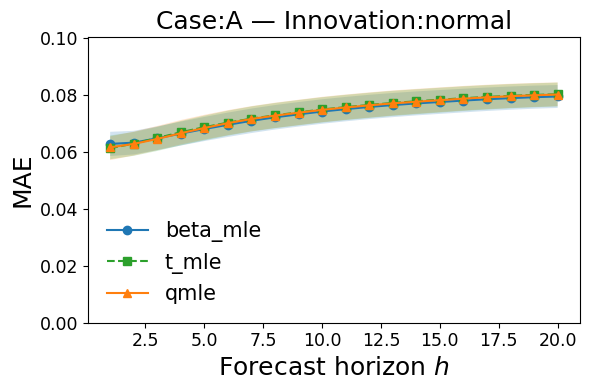

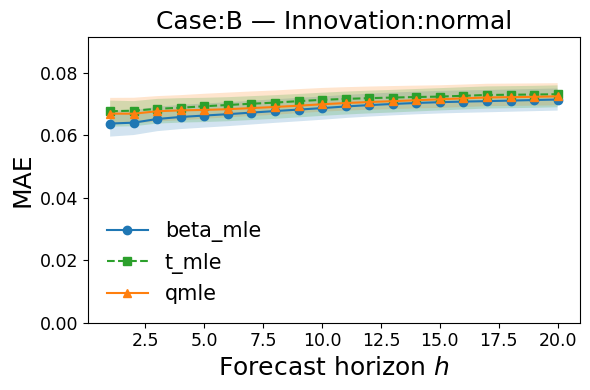

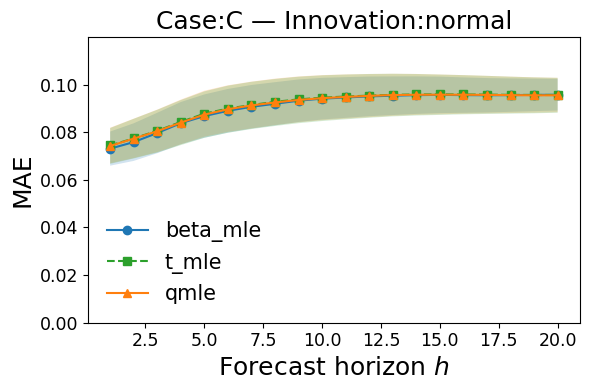

In [183]:
cases = [
    ('A', 'normal', 'None'),
    ('B', 'normal', 'None'),
    ('C', 'normal', 'None')
]

for case, innov_type, innov_param in cases:
    fname = f"plot_{case}_{innov_type}_{innov_param}.pdf".replace(" ", "")
    plot_metric_for_dgp(dfM, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, metric='MAE',
                        savepath=fname)

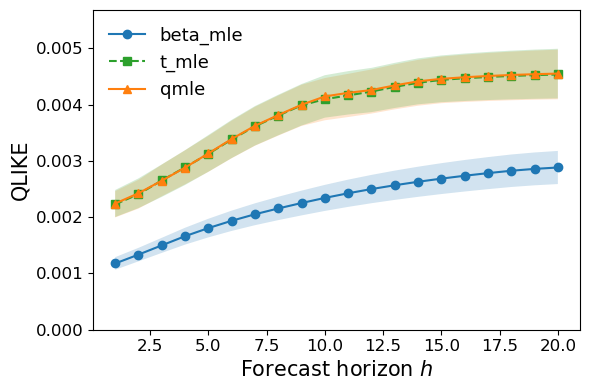

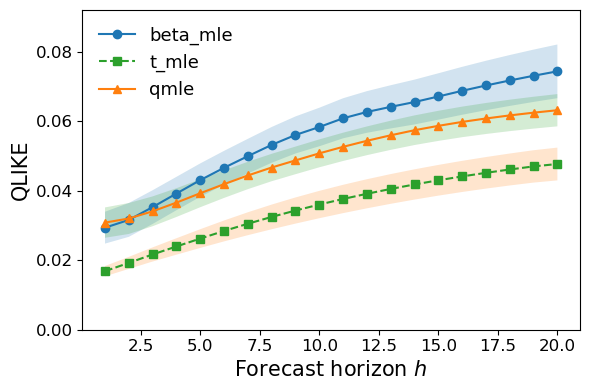

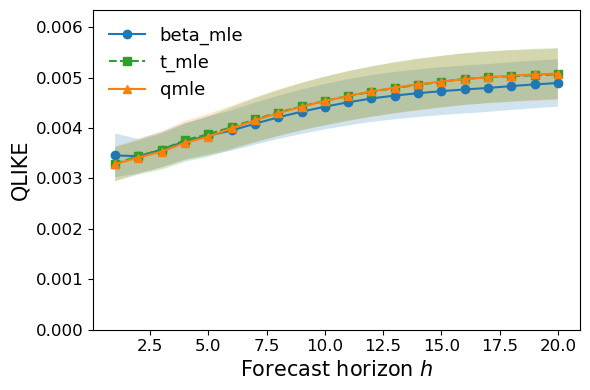

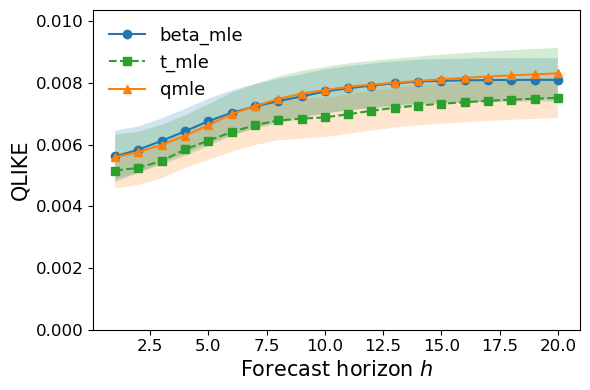

In [ ]:
#plot_metric_for_dgp(dfM, case='A', dgp_innov_type='Beta',   dgp_innov_param='(2, 5)', metric='QLIKE')
#plot_metric_for_dgp(dfM, case='A', dgp_innov_type='t',   dgp_innov_param='3', metric='QLIKE')
#plot_metric_for_dgp(dfM, case='A', dgp_innov_type='normal',   dgp_innov_param='None', metric='QLIKE')
#plot_metric_for_dgp(dfM, case='A', dgp_innov_type='t',   dgp_innov_param='8', metric='QLIKE')
cases = [
    ('A', 'Beta', '(2, 5)'),
    ('A', 't', '3'),
    ('A', 'normal', 'None'),
    ('A', 't', '8')
]

for case, innov_type, innov_param in cases:
    fname = f"plot_{case}_{innov_type}_{innov_param}.pdf".replace(" ", "")
    plot_metric_for_dgp(dfM, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, metric='QLIKE',
                        savepath=fname)

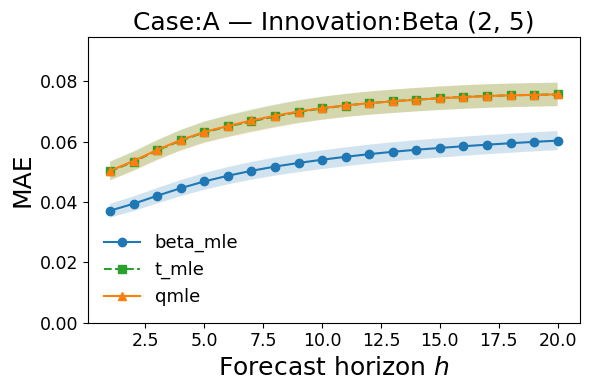

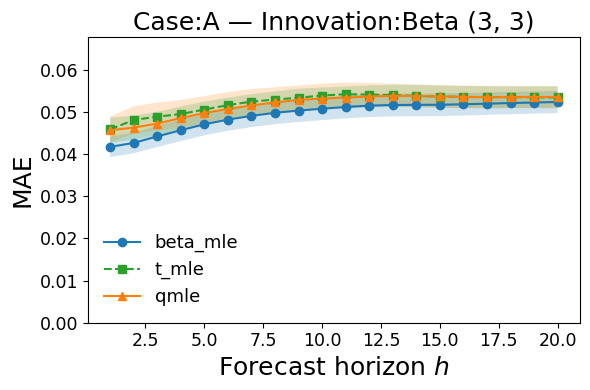

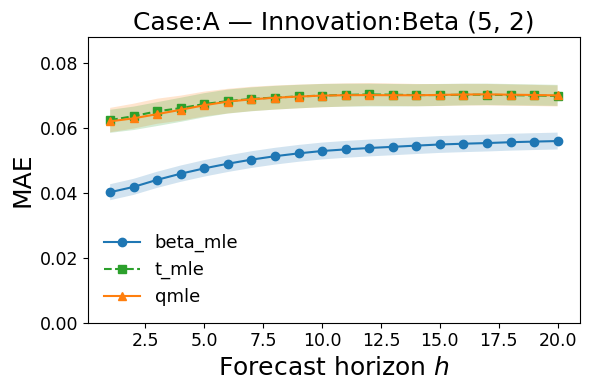

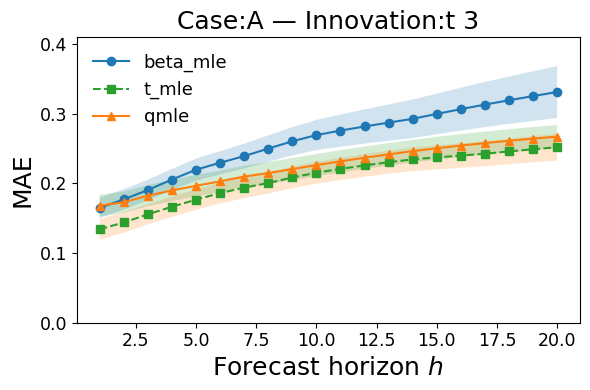

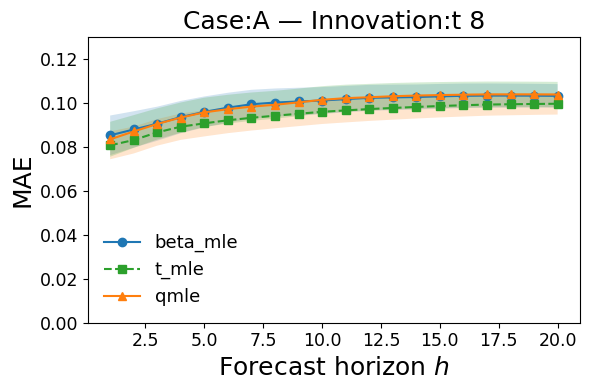

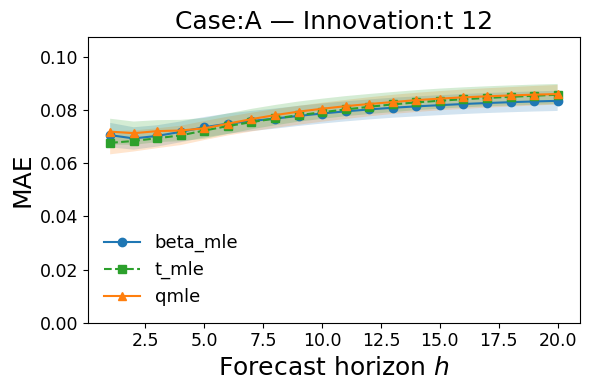

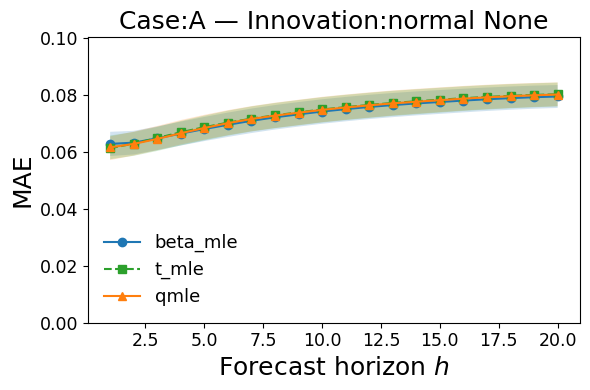

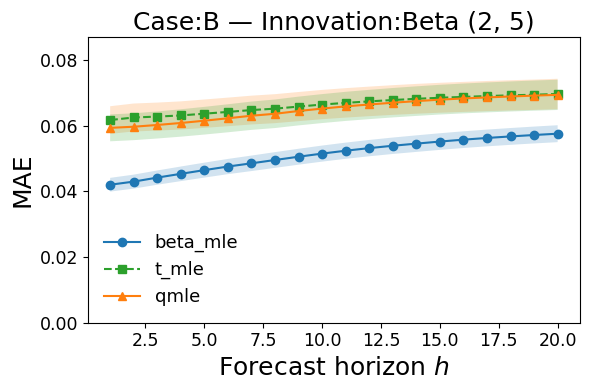

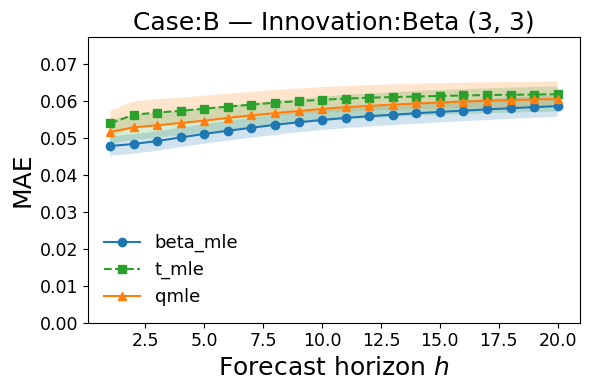

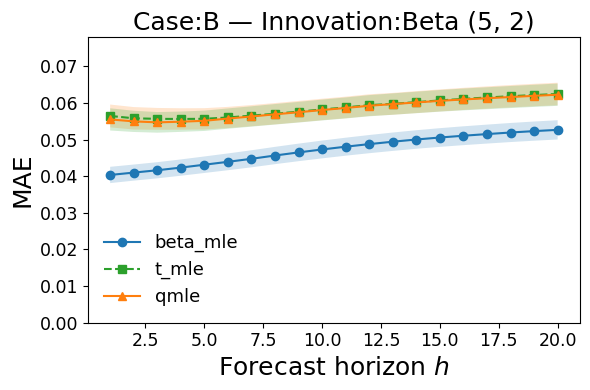

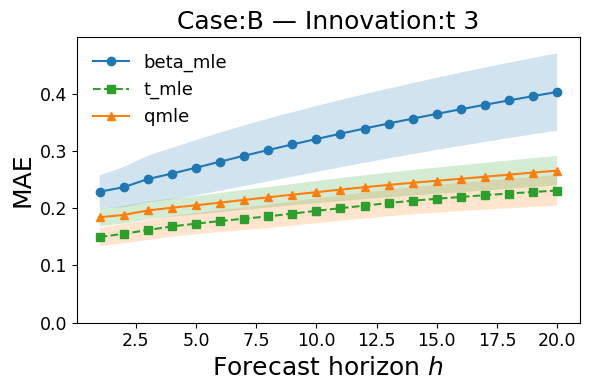

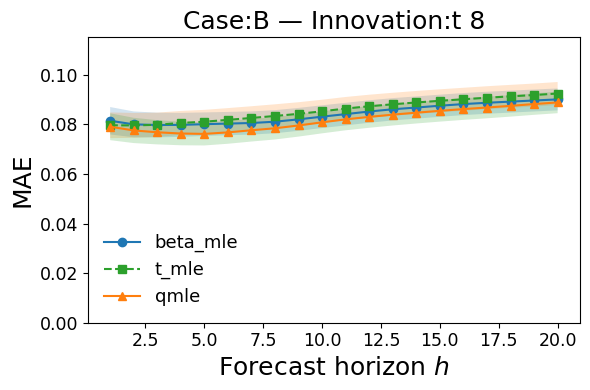

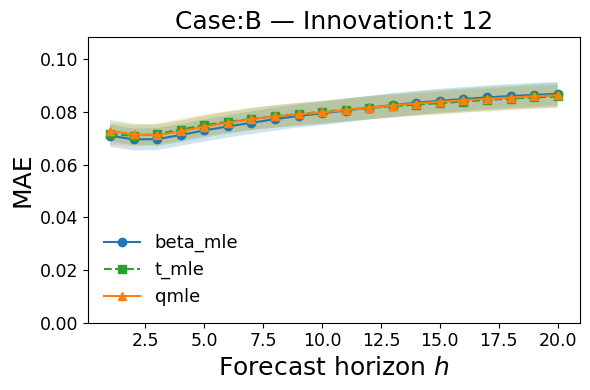

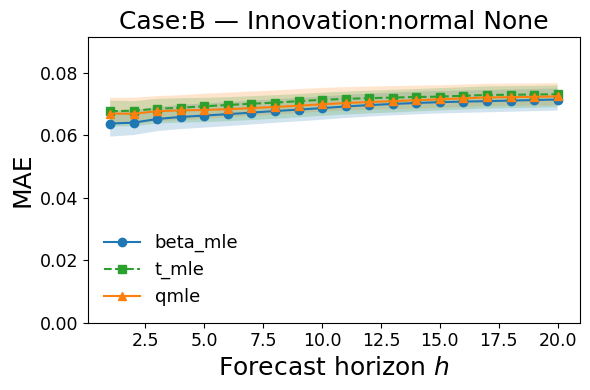

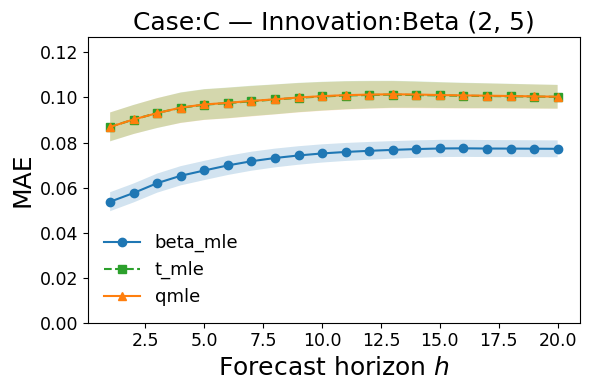

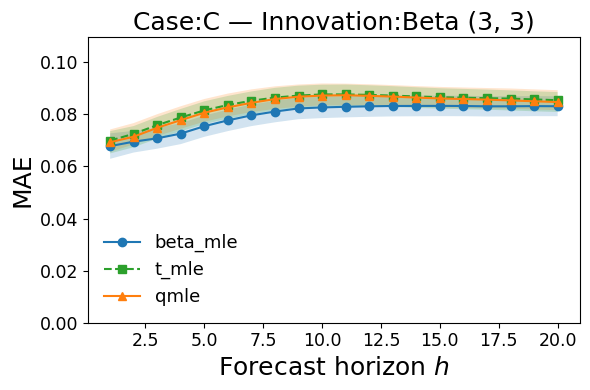

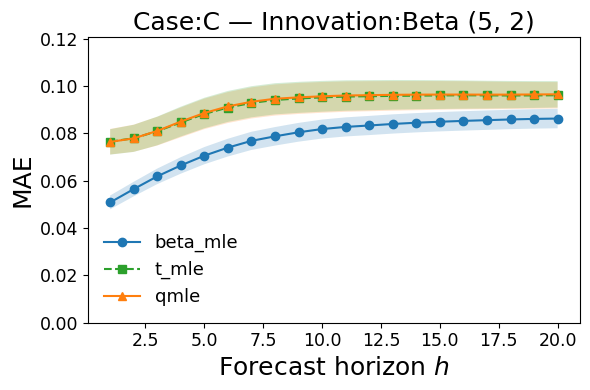

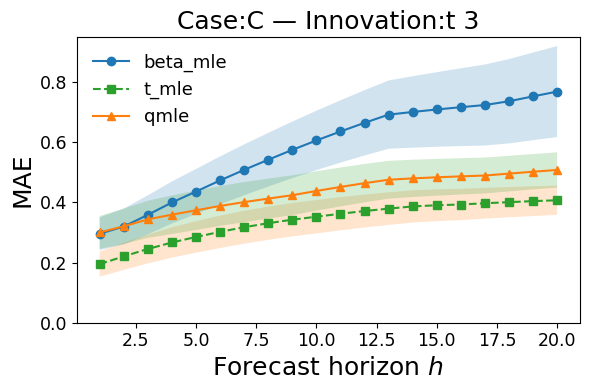

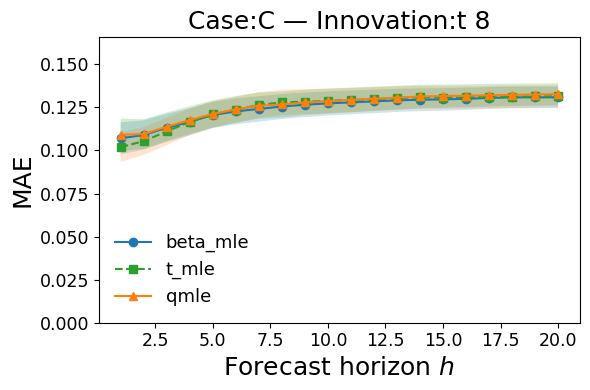

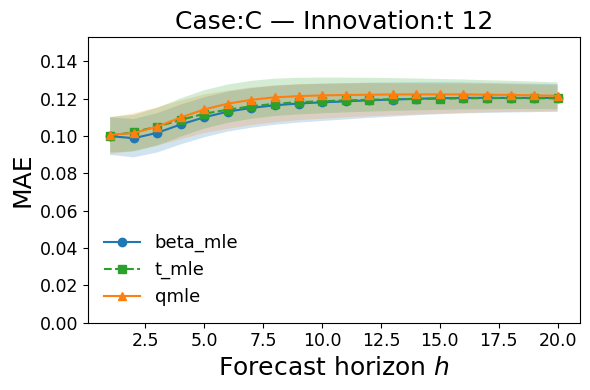

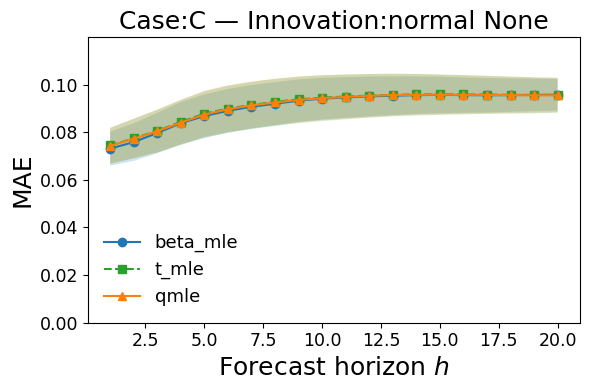

In [172]:
cases = [
    ('A', 'Beta', '(2, 5)'),
    ('A', 'Beta', '(3, 3)'),
    ('A', 'Beta', '(5, 2)'),
    ('A', 't', '3'),
    ('A', 't', '8'),
    ('A', 't', '12'),
    ('A', 'normal', 'None'),
    ('B', 'Beta', '(2, 5)'),
    ('B', 'Beta', '(3, 3)'),
    ('B', 'Beta', '(5, 2)'),
    ('B', 't', '3'),
    ('B', 't', '8'),
    ('B', 't', '12'),
    ('B', 'normal', 'None'),
    ('C', 'Beta', '(2, 5)'),
    ('C', 'Beta', '(3, 3)'),
    ('C', 'Beta', '(5, 2)'),
    ('C', 't', '3'),
    ('C', 't', '8'),
    ('C', 't', '12'),
    ('C', 'normal', 'None')
    
]

for case, innov_type, innov_param in cases:
    fname = f"plot_{case}_{innov_type}_{innov_param}_MAE.pdf".replace(" ", "")
    plot_metric_for_dgp(dfM, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, metric='MAE',
                        savepath=fname)

In [310]:
def plot_var_rejection_rates_for_dgp(
    df_var_summary: pd.DataFrame,
    case, dgp_innov_type, dgp_innov_param,
    test: str = 'UC',                 # 'UC' or 'IND' or 'CC'
    alpha_filter: float | None = None,
    estimators: list[str] | None = None,
    test_alpha_line: float | None = 0.05,  # rejection ratio baseline
    use_crit: float = 1,              # 1 => ±1*SE; 1.96 => ~95%CI
    robust_ylim: bool = True,
    title: str | None = None,
    colors: dict[str,str] | None = None,
    markers: dict[str,str] | None = None,
    linestyles: dict[str,str] | None = None,
    figsize=(6,4),
    savepath: str | None = None      
):
    import numpy as np
    import matplotlib.pyplot as plt

    test = test.upper()
    if test not in ('UC','IND', 'CC'):
        raise ValueError("test must be 'UC' or 'IND'")

    rate_col = f'{test}_rate'
    se_col   = f'{test}_mcse'

    sub = df_var_summary[
        (df_var_summary['case']==case) &
        (df_var_summary['dgp_innov_type']==dgp_innov_type) &
        (df_var_summary['dgp_innov_param']==dgp_innov_param)
    ].copy()
    if alpha_filter is not None:
        sub = sub[np.isclose(sub['alpha'], alpha_filter)]

    if sub.empty:
        print("No data for specified DGP/test/alpha.")
        return

    if estimators is None:
        estimators = ['beta_mle','t_mle','qmle']
    if colors is None:
        colors = {'beta_mle':'tab:blue', 'qmle':'tab:orange','t_mle':'tab:green'}
    if markers is None:
        markers = {'beta_mle':'o', 't_mle':'s', 'qmle':'^'}
    if linestyles is None:
        linestyles = {'beta_mle':'-', 't_mle':'--', 'qmle':'-'}

    plt.figure(figsize=figsize)
    for est in estimators:
        d = (sub[sub['estimator']==est].sort_values(['alpha','h_var']))
        if d.empty:
            continue
        h  = d['h_var'].to_numpy()
        r  = d[rate_col].to_numpy()
        se = d[se_col].to_numpy()

        plt.plot(h, r, label=f"{est}",
                 color=colors.get(est), marker=markers.get(est),
                 linestyle=linestyles.get(est))
        if np.isfinite(se).any():
            plt.fill_between(h, r - use_crit*se, r + use_crit*se,
                             alpha=0.2, color=colors.get(est))

    plt.xlabel('Forecast horizon $h$', fontsize = 18)
    plt.ylabel(f'{test} rejection rate', fontsize = 18)
    plt.tick_params(axis='both', which='major', labelsize=12.5)
    if title is None:
        a_text = (f"α={alpha_filter}" if alpha_filter is not None
                  else f"α∈{{{', '.join(map(str, sorted(sub['alpha'].unique())))}}}")
        title = f"Case{case} - {dgp_innov_type} {dgp_innov_param} - {test} - VaR level α = {alpha_filter}"
    plt.title(title, fontsize = 18)
    if test_alpha_line is not None:
        plt.axhline(test_alpha_line, linestyle=':', linewidth=1.2, alpha=0.8)

    if robust_ylim:
        y = sub[rate_col].to_numpy()
        if np.isfinite(y).any():
            lo = max(0.0, np.nanmin(y) - 0.05)
            hi = min(1.0, np.nanpercentile(y, 99) * 1.25 + 0.02)
            plt.ylim(lo, hi)

    plt.legend(loc='best', fontsize = 13, frameon=False)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, format="pdf", bbox_inches="tight")
        plt.close()
    else:
        plt.show()

In [309]:
for case, innov_type, innov_param in cases:
    fname = f"plot_{case}_{innov_type}_{innov_param}_UC.pdf".replace(" ", "")
    plot_var_rejection_rates_for_dgp(dfV, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, test='UC',alpha_filter=0.05,estimators=['beta_mle','t_mle','qmle'],test_alpha_line=0.05,     # baseline
                        use_crit=1,             # ±1*SE, same as in the QLIKE plot
                        savepath=fname)
for case, innov_type, innov_param in cases:
    fname = f"plot_{case}_{innov_type}_{innov_param}_IND.pdf".replace(" ", "")
    plot_var_rejection_rates_for_dgp(dfV, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, test='IND',alpha_filter=0.05,estimators=['beta_mle','t_mle','qmle'],test_alpha_line=0.05,     
                        use_crit=1,            
                        savepath=fname)
for case, innov_type, innov_param in cases:
    fname = f"plot_{case}_{innov_type}_{innov_param}_CC.pdf".replace(" ", "")
    plot_var_rejection_rates_for_dgp(dfV, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, test='CC',alpha_filter=0.05,estimators=['beta_mle','t_mle','qmle'],test_alpha_line=0.05,     
                        use_crit=1,            
                        savepath=fname)

In [307]:
cases2 = [
    ('A', 'Beta', '(2, 5)'),
    ('A', 't', '3'),
    ('A', 't', '8'),
    ('A', 'normal', 'None')
]
for case, innov_type, innov_param in cases2:
    fname = f"plot_{case}_{innov_type}_{innov_param}_CC.pdf".replace(" ", "")
    plot_var_rejection_rates_for_dgp(dfV, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, test='CC',alpha_filter=0.05,estimators=['beta_mle','t_mle','qmle'],test_alpha_line=0.05,     
                        use_crit=1,            
                        savepath=fname)

In [314]:
cases2 = [
    ('A', 'normal', 'None'),
    ('B', 'normal', 'None'),
    ('C', 'normal', 'None')
]
for case, innov_type, innov_param in cases2:
    fname = f"plot_{case}_{innov_type}_{innov_param}_UC.pdf".replace(" ", "")
    plot_var_rejection_rates_for_dgp(dfV, case=case, dgp_innov_type=innov_type,
                        dgp_innov_param=innov_param, test='UC',alpha_filter=0.05,estimators=['beta_mle','t_mle','qmle'],test_alpha_line=0.05,     
                        use_crit=1,            
                        savepath=fname)

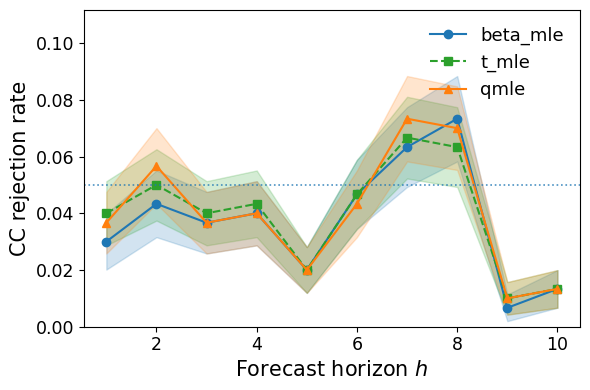

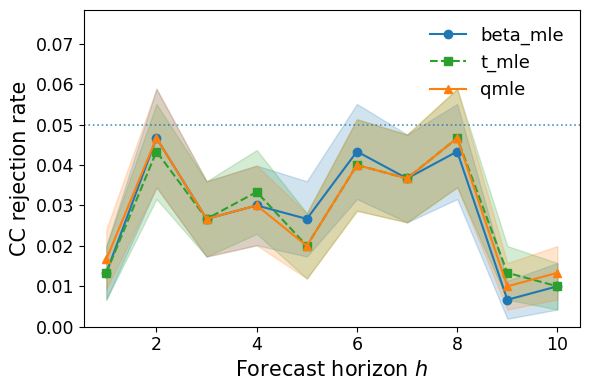

In [303]:
plot_var_rejection_rates_for_dgp(
    dfV,
    case='A',
    dgp_innov_type='t',
    dgp_innov_param='12',
    test='CC',
    alpha_filter=0.05,      
    estimators=['beta_mle','t_mle','qmle'],
    test_alpha_line=0.05,     # baseline
    use_crit=1             # ±1*SE, same as in the QLIKE plot
)
plot_var_rejection_rates_for_dgp(
    dfV,
    case='A',
    dgp_innov_type='normal',
    dgp_innov_param='None',
    test='CC',
    alpha_filter=0.05,
    use_crit=1,            
    test_alpha_line=0.05
)

